### IDs:
Insert yours IDs to the cell below

ID #1: 205634272

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
1. You are free to add cells.
1. Write your functions and your answers in this jupyter notebook only.
1. Answers to theoretical questions should be written in **markdown cells (with $\LaTeX$ support)**.
1. Submit this jupyter notebook only using your ID as a filename. Not to use ZIP or RAR. For example, your Moodle submission file name should look like this (two id numbers): `123456789_987654321.ipynb`.

# Imports and Set-Up

In [1]:
import os

In [2]:
import pandas as pd
import scipy.stats as st
from IPython.display import display, HTML, Math, Latex
from scipy.stats import multivariate_normal as mn
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import __all__
from scipy.stats import *
from scipy.stats import distributions as dt
from concurrent.futures import ThreadPoolExecutor, as_completed, TimeoutError
from tqdm import tqdm
import warnings
from itertools import combinations


%matplotlib inline

plt.rc('font', size=14)
plt.rc('axes', titlesize=14)

In [3]:
class PlotMover:
    # based on SeabornFig2Grid
    def __init__(self, joint_plot, target_fig, subplot_loc):
        self.joint_plot = joint_plot
        self.target_fig = target_fig
        self.subplot_loc = subplot_loc
        self._move_plot()
        self._cleanup_figure()
    
    def _move_plot(self):
        joint_height = self.joint_plot.ax_joint.get_position().height
        marg_x_height = self.joint_plot.ax_marg_x.get_position().height
        num_rows = int(np.round(joint_height / marg_x_height))
        self._resize_plot()
        subplot_grid = gridspec.GridSpecFromSubplotSpec(num_rows+1, num_rows+1, subplot_spec=self.subplot_loc)
        self._move_subplot(self.joint_plot.ax_joint, subplot_grid[1:, :-1])
        self._move_subplot(self.joint_plot.ax_marg_x, subplot_grid[0, :-1])
        self._move_subplot(self.joint_plot.ax_marg_y, subplot_grid[1:, -1])
    
    def _move_subplot(self, subplot, subplot_grid_loc):
        subplot.remove()
        subplot.figure = self.target_fig
        self.target_fig.axes.append(subplot)
        self.target_fig.add_axes(subplot)
        subplot._subplotspec = subplot_grid_loc
        subplot.set_position(subplot_grid_loc.get_position(self.target_fig))
        subplot.set_subplotspec(subplot_grid_loc)
    
    def _cleanup_figure(self):
        plt.close(self.joint_plot.fig)
        self.target_fig.canvas.mpl_connect("resize_event", lambda evt: self._resize_plot())
        self.target_fig.canvas.draw()
    
    def _resize_plot(self):
        self.joint_plot.fig.set_size_inches(self.target_fig.get_size_inches())

### Question 1 - Correlations (14 points)

Provide example datapoints matching the following descriptions. Each example should be constructed over n=50 datapoints. Provide a table description of the example data as well as a jointplot (see example below). 
If you think that the situation described is impossible then clearly explain why (you don’t need to give a rigorous proof).<br>
Pearson(x,y) = Pearson correlation<br>
τ(x,y) = Kendall rank correlation<br>
ρ(x,y) = Spearman rank correlation <br>
<img src="jointplot.png">

In [4]:
n = 50

In [5]:
def solution(x, y):
    plot = sns.jointplot(x = x, y = y, marker='o').fig.suptitle('Jointplot of x and y', va="bottom", fontsize=16)
    #plot.show()
    display(pd.DataFrame(np.c_[x,y], columns = ['x', 'y']).describe())

#### 1.A
Data in which  $Pearson(x,y) < -0.9$ but where $n-1$ points can be selected so that for the vectors restricted to those we have $Pearson(x_{n-1},y_{n-1}) > 0.9$

<div class="alert alert-block alert-info">
We can build, for example, a dataset with first $n-1$ points showing a strong positive correlation as requested, and add to it the n-th point which is a very stong outlier so that it drive the pearson correlation of the whole dataset in the opposite direction:
</div>

In [6]:
rng = np.random.default_rng(123)

# take n-1 points with large correlation as required (>0.9):
x = rng.normal(loc=0.0, scale=1, size=n-1)
y = x+rng.normal(loc=0.0, scale=0.5, size=n-1) # add some noise to y so that correlation is not exavtly 1

# now add an extreme outlier which makes the correlation < -0.9 when all n points are considered:

x1 = np.append(x, 25)
y1 = np.append(y, -40)

In [7]:
print("Pearson correlation of the first n-1 points: ", end="")
print(np.corrcoef(x,y)[0,1])
print("Pearson correlation of all n points: ", end="")
print(np.corrcoef(x1,y1)[0,1])

Pearson correlation of the first n-1 points: 0.9258730400934347
Pearson correlation of all n points: -0.9022710432388206


,x,y
count,50.000000,50.000000
mean,0.670196,-0.649753
std,3.647206,5.771644
min,-2.207471,-40.000000
25%,-0.369557,-0.661810
50%,0.150351,0.097478
75%,0.998533,0.848705
max,25.000000,2.214587


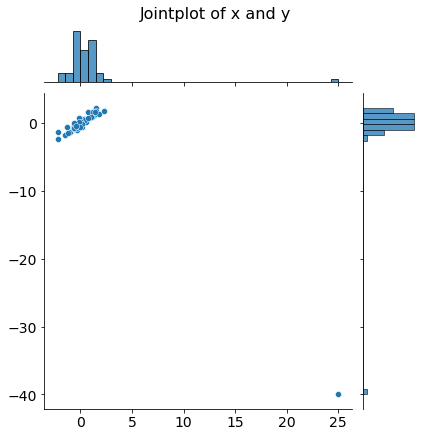

In [8]:
solution(x1,y1)

#### 1.B
Data in which  $\rho(x,y) = 1$ but where $n-1$ points can be selected so that for the vectors restricted to those we have $\rho(x_{n-1},y_{n-1}) < 0.9$

<div class="alert alert-block alert-info">
This is impossible. Indeed, Spearman correlation of 1 indicates that the ranks of all $n$ observations correlate perfectly. In other words, observation $i_1$ that happens to have rank 1 of its $x$ value will also have rank 1 of its $y$ valu; observation $i_2$ that has rank 2 of its $x$ value will also have rank 2 of its $y$ value and so forth. We can always sort the observations by ranks (of either $x$ or $y$ values, sonce they are the same anyway), so the table of the *ranks* after such rearrangement will look as follows:

<p>
    
|observation_id | X rank | Y rank|
|:--|---|---|
|  $i_1$        |  1     | 1 |
|  $i_2$        |  2     | 2 |
|  $i_3$        |  3     | 3 |
|   ...         |  ...   |  ... |    
   
<p>
Clearly if we remove *any* observation (from any line of that table) that has the *same* rank $r$ in both $x$ and $y$ variables, the ranks of all the observations past the one we removed will just decrease by 1 (for *both* $x$ and $y$) but the rank $r_x$ in $x$ and the rank $r_y$ in $y$ for any observation will remain equal, $r_x=r_y$. Thus, the pearson correlation of the ranks of the remaining $n-1$ data points (which is by definition the spearman correlation of the original data in vectors $x_{n-1}$, $y_{n-1}$ will remain equal to 1. 
    
Thus we *cannot* decrease the spearman correlation of 1 by removing a datapoint.
</div>    

#### 1.C
Data with τ(x,y) > ρ(x,y) + 0.45

In [9]:
x = np.arange(1, n + 1)
y = np.r_[np.arange(25, 50, 1), np.arange(0, 25, 1)]

In [10]:
print("Kendall tau:", end="")
print(st.kendalltau(x, y).correlation)
print("Spearman: ", end="")
print(st.spearmanr(x, y).correlation)
print("Kendall-Spearman > .45: ", end="")
print(st.kendalltau(x, y).correlation - st.spearmanr(x, y).correlation)

Kendall tau:-0.020408163265306124
Spearman: -0.5006002400960383
Kendall-Spearman > .45: 0.4801920768307322


,x,y
count,50.00000,50.00000
mean,25.50000,24.50000
std,14.57738,14.57738
min,1.00000,0.00000
25%,13.25000,12.25000
50%,25.50000,24.50000
75%,37.75000,36.75000
max,50.00000,49.00000


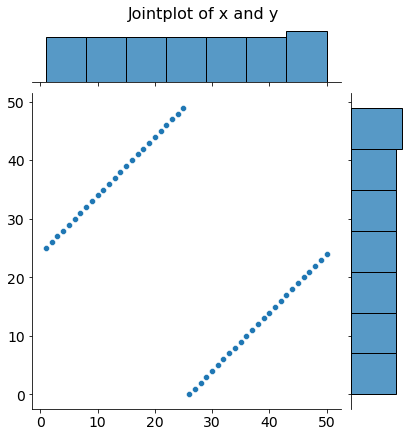

In [11]:
solution(x, y)

#### 1.D
Data with τ(x,y) < ρ(x,y) – 0.45

In [12]:
x = np.arange(1, n + 1)
y = np.r_[np.arange(25, 0, -1 ), np.arange(50, 25, -1)]

In [13]:
print("Kendall tau:", end="")
print(st.kendalltau(x, y).correlation)
print("Spearman: ", end="")
print(st.spearmanr(x, y).correlation)
print("Kendall-Spearman < -.45: ", end="")
print(st.kendalltau(x, y).correlation - st.spearmanr(x, y).correlation)

Kendall tau:0.020408163265306124
Spearman: 0.5006002400960383
Kendall-Spearman < -.45: -0.4801920768307322


,x,y
count,50.00000,50.00000
mean,25.50000,25.50000
std,14.57738,14.57738
min,1.00000,1.00000
25%,13.25000,13.25000
50%,25.50000,25.50000
75%,37.75000,37.75000
max,50.00000,50.00000


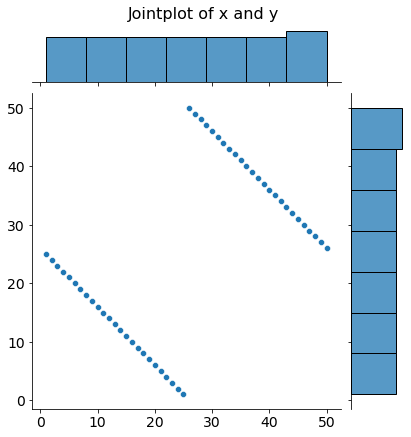

In [14]:
solution(x, y)

#### 1.E
Data with Pearson(x,y) < ρ(x,y) – 0.6

In [15]:
x = np.arange(1, n + 1, dtype=np.int64)
y = np.int64(np.power(2.2, x))

In [16]:
print("Pearson: ", end="")
print(st.pearsonr(x, y)[0])
print("Spearman: ", end="")
print(st.spearmanr(x, y).correlation)
print("Pearson-Spearman < -.6: ", end="")
print(st.pearsonr(x, y)[0] - st.spearmanr(x, y).correlation)

Pearson: 0.3892650479784921
Spearman: 0.9999999999999999
Pearson-Spearman < -.6: -0.6107349520215077


,x,y
count,50.00000,5.000000e+01
mean,25.50000,4.846246e+15
std,14.57738,2.062489e+16
min,1.00000,2.000000e+00
25%,13.25000,3.676525e+04
50%,25.50000,5.816838e+08
75%,37.75000,8.879588e+12
max,50.00000,1.321704e+17


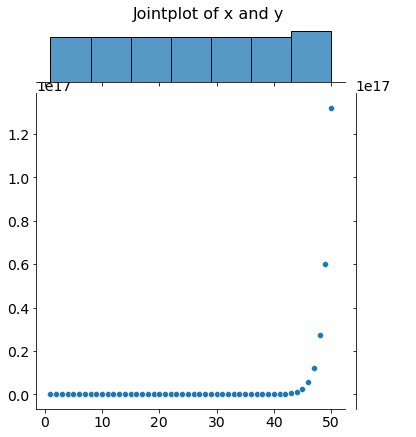

In [17]:
solution(x, y)

#### 1.F
Data with Pearson(x,y) > ρ(x,y) + 1.2

In [18]:
x = np.r_[np.arange(1, n), [200]]
y = np.r_[np.arange(49, 0, -1 ), [200]]

In [19]:
print("Pearson: ", end="")
print(st.pearsonr(x, y)[0])
print("Spearman: ", end="")
print(st.spearmanr(x, y).correlation)
print("Pearson-Spearman > 1.2: ", end="")
print(st.pearsonr(x, y)[0] - st.spearmanr(x, y).correlation)

Pearson: 0.5076923076923077
Spearman: -0.8823529411764706
Pearson-Spearman > 1.2: 1.3900452488687782


,x,y
count,50.000000,50.000000
mean,28.500000,28.500000
std,28.504386,28.504386
min,1.000000,1.000000
25%,13.250000,13.250000
50%,25.500000,25.500000
75%,37.750000,37.750000
max,200.000000,200.000000


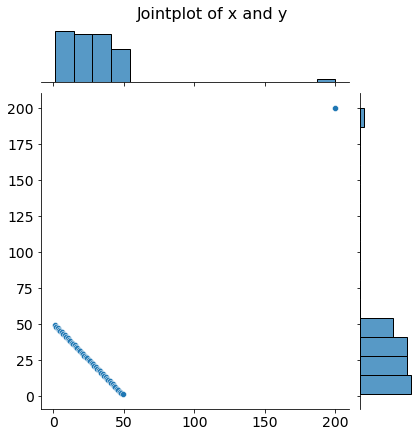

In [20]:
solution(x, y)

#### 1.G
Data with τ(x,y) < ρ(x,y) – 1.2 

<div class="alert alert-block alert-info">

This seems to be impossible.
All correlation coefficients are bounded between [-1,1]. So, for instance, if $\tau=-1$, the smallest possible value, then we must have $\rho>0.2$ for the Spearmann correlation to have the desired inequality hold. For larger values of $\tau$ even larger $\rho$ would be required (in other words, we *always* must have at least $\rho > 0.2$). 
    
Similarly, since $\rho$ cannot be greater than 1, the inequality would suggest that $\tau$ is always less than -0.2. Combined, this suggests that the data must have positive spearman correlation ($\rho > 0.2$) but negative kendall correlation ($\tau < -0.2$) at the same time, at the very least. This is suspicious enough, and in fact for any given ($\tau$ or $\rho$) the gap between the specific values obtained for such purported dataset would be even larger (> 1.2 !!), i.e. the desired values would look something like 0.7 and -0.55 -- this is a huge gap between two correlation coefficients, one suggesting a very stron positive rank-correlation while the other suggesting a very strong negative one. While kendall and spearmann correlations are not equivalent numerically, of course, such a drastic difference between the two, with the opposite signs of rank correlation suggested, looks implausible.
    
</div>

### Question 2 - Analysis of the UCI Heart Disease dataset  (38 points)

Perform data analysis on the UCI Heart Disease Dataset
References:
1. Detrano, R., Janosi, A., Steinbrunn, W., Pfisterer, M., Schmid, J., Sandhu, S., Guppy, K., Lee, S., & Froelicher, V. (1989). International application of a new probability algorithm for the diagnosis of coronary artery disease. American Journal of Cardiology, 64,304--310.
2. David W. Aha & Dennis Kibler. "Instance-based prediction of heart-disease presence with the Cleveland database."
3. Gennari, J.H., Langley, P, & Fisher, D. (1989). Models of incremental concept formation. Artificial Intelligence, 40, 11--61.

Use the following links to find the details of the data: 
1. https://archive.ics.uci.edu/ml/datasets/heart+disease
2. https://www.kaggle.com/ronitf/heart-disease-uci

In the follwing cells write a report for your analysis. In your report provide a clear description of the analysis methods and of the results. This should include a graphical representation of the results and the conclusions. Provide p-values or other indicators of the statistical significance where appropriate. <br>
Design your report to be concise but still cover interesting findings.

There are missing values in the data. Find them and impute them by using the median (for numerical features) or the mode (for categorical features) value of the relevant feature (column).
Address the following questions:
* Using confidence intervals determine for which numerical features you can state with confidence of 95% that the healthy population (target = 0) mean is larger/smaller than the disease population (target = 1) mean. 
* Draw histograms for each numerical feature. Inspect the observed distributions and then use MLE to plot, on the same figures, fits of the distributions.
* For each pair of numerical feature, calculate correlations and indicate whether you find them significant. For select pairs, with significant correlations, draw joint plot with marginal histograms (see Seaborn joint plot) and find bivariate normal fits. Then use the example code below to draw plots of the bivariate pdfs (you may edit the code as you see fit).
* Are there pairs that are significantly correlated in males but not in females? The opposite? How about healthy vs disease? Can you graphically represent this?
* For each numerical feature, except age, plot the distribution for this feature against bins of age. In each bin provide a split violin plot, with different colors for healthy and disease.

Suggest, state and address at least one original question.


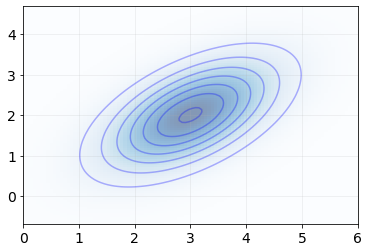

In [21]:
# Example code for bivariate pdfs

def plot_2d_Gaussian_pdf(means, cov, ax=None):
    n = 100
    x1 = np.linspace(means[0] - 3 * np.sqrt(cov[0][0]), means[0] + 3 * np.sqrt(cov[0][0]), n)
    x2 = np.linspace(means[1] - 3 * np.sqrt(cov[1][1]), means[1] + 3 * np.sqrt(cov[1][1]), n)
    x1_v, x2_v = np.meshgrid(x1, x2)
    Xgrid = np.vstack([x1_v.ravel(), x2_v.ravel()]).T
    Y = mn.pdf(Xgrid, means, cov)

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()
        ax = fig.add_subplot(ax)
    ax.pcolorfast(x1, x2, Y.reshape(x1_v.shape), alpha=0.5, cmap='Blues')
    ax.contour(x1_v, x2_v, Y.reshape(x1_v.shape), alpha=0.3, colors='b')
    ax.grid(alpha=0.2)
    return ax

    
    
means = [3, 2]
cov = [[1, 0.5], [0.5, 0.8]]
plot_2d_Gaussian_pdf(means, cov);

#### Exploring the Data

<div class="alert alert-info">
The full database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. The dataset has missing values and attributes are of categorical, integer, and real types. The dataset contains 303 instances and is multivariate.
    
The attributes are:
- age: the age in years
- sex: 1 for males, 0 for females
- cp: chest pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
- trestbps: resting blood pressure (in mm Hg on admission to the hospital)
- chol: serum cholestoral in mg/dl
- fbs: if fasting blood sugar > 120 mg/dl then 1 else 0
- restecg: resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- thalach: maximum heart rate achieved
- exang: exercise induced angina (1 = yes; 0 = no)
- oldpeak: ST depression induced by exercise relative to rest
- slope: the slope of the peak exercise ST segment
    - Value 1: upsloping
    - Value 2: flat
    - Value 3: downsloping
- ca: number of major vessels (0-3) colored by flourosopy
- thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
- num: diagnosis of heart disease (angiographic disease status)
    - Value 0: < 50% diameter narrowing
    - Value 1: > 50% diameter narrowing
    
    </div>

In [22]:
df = pd.read_csv('heart.csv', index_col=False, sep='\t')

<div class="alert alert-info">
A number of variables represent catgorical data (encoded by integers 0, 1, ...). Let us convert them to object type first:
    </div>

In [23]:
df['sex']=pd.Series(np.where(np.isnan(df.sex), pd.NA, np.where(df.sex==1,"M","F"))).astype('category')
df['cp']=pd.Series(np.where(np.isnan(df.cp), pd.NA, np.where(df.cp==1,"typical_angina",np.where(df.cp==2,"atypical_angina", np.where(df.cp==3,"non_anginal","asymptomatic"))))).astype('category')
df['fbs']=pd.Series(np.where(np.isnan(df.fbs), pd.NA, np.where(df.fbs==1,"high","low"))).astype('category')
df['restecg']=pd.Series(np.where(np.isnan(df.restecg), pd.NA, np.where(df.restecg==0,"normal",np.where(df.restecg==1,"ST_T_abnorm","lvh")))).astype('category')
df['exang']=pd.Series(np.where(np.isnan(df.exang), pd.NA, np.where(df.exang==1,"yes","no"))).astype('category')
df['slope']=pd.Series(np.where(np.isnan(df.slope), pd.NA, np.where(df.slope==1,"up",np.where(df.slope==2,"flat","down")))).astype('category')
df['thal']=pd.Series(np.where(np.isnan(df.thal), pd.NA, np.where(df.thal==3,"normal",np.where(df.thal==6,"fixed","reversable")))).astype('category')
df['target']=pd.Series(np.where(np.isnan(df.target), pd.NA, np.where(df.target==1,"disease","healthy"))).astype('category')

In [24]:
df.target.value_counts(dropna=False)

disease    165
healthy    138
Name: target, dtype: int64

In [25]:
df.cp.value_counts(dropna=False)

asymptomatic       140
atypical_angina     85
typical_angina      50
non_anginal         23
NaN                  5
Name: cp, dtype: int64

In [26]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,M,non_anginal,145.0,233.0,high,normal,150.0,no,2.3,down,0,reversable,disease
1,37.0,M,NaN,130.0,250.0,low,ST_T_abnorm,187.0,no,3.5,down,0,reversable,disease
2,41.0,F,typical_angina,NaN,NaN,low,normal,172.0,no,1.4,flat,0,reversable,disease
3,NaN,M,typical_angina,120.0,236.0,low,ST_T_abnorm,178.0,no,0.8,flat,0,reversable,disease
4,NaN,F,asymptomatic,120.0,354.0,low,ST_T_abnorm,163.0,yes,0.6,flat,0,reversable,disease


<div class="alert alert-info">
Descriptive statistics for numerical variables:
    </div>

In [27]:
df.describe()

,age,trestbps,chol,thalach,oldpeak,ca
count,295.000000,297.000000,297.000000,299.000000,298.000000,303.000000
mean,54.389831,131.663300,245.966330,149.565217,1.040604,0.729373
std,9.084668,17.532242,52.117969,23.008131,1.167458,1.022606
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000
25%,47.500000,120.000000,211.000000,133.000000,0.000000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000,0.000000
75%,61.000000,140.000000,274.000000,166.000000,1.600000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,4.000000


<div class="alert alert-info">
Descriptive statistics for categorical variables:
    </div>

In [28]:
df.describe(include='category')

,sex,cp,fbs,restecg,exang,slope,thal,target
count,299,298,300,301,303,303,303,303
unique,2,4,2,3,2,3,2,2
top,M,asymptomatic,low,ST_T_abnorm,no,flat,reversable,disease
freq,204,140,255,151,204,142,186,165


There are missing values in the data. Find them and impute them by using the median (for numerical features) or the mode (for categorical features) value of the relevant feature (column). 

In [29]:
df = df.apply(lambda x: x.fillna(x.mode()[0] if x.dtype.name == 'category' else x.median()))

<div class="alert alert-info">
Let us look at the numeric and categorical descriptive statistics again:
    </div>

In [30]:
df.describe()

,age,trestbps,chol,thalach,oldpeak,ca
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.405941,131.630363,245.848185,149.610561,1.036634,0.729373
std,8.964069,17.358758,51.604360,22.858624,1.158160,1.022606
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000
25%,48.000000,120.000000,211.000000,133.500000,0.000000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000,0.000000
75%,61.000000,140.000000,274.000000,166.000000,1.600000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,4.000000


In [31]:
df.describe(include='category')

,sex,cp,fbs,restecg,exang,slope,thal,target
count,303,303,303,303,303,303,303,303
unique,2,4,2,3,2,3,2,2
top,M,asymptomatic,low,ST_T_abnorm,no,flat,reversable,disease
freq,208,145,258,153,204,142,186,165


Using confidence intervals determine for which numerical features you can state with confidence of 95% that the healthy population (target = 0) mean is larger/smaller than the disease population (target = 1) mean.

In [32]:
numerical_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [33]:
healthy = df[df['target'] == 'healthy'][numerical_features]
healthy.head()

,age,trestbps,chol,thalach,oldpeak
165,67.0,160.0,286.0,108.0,1.5
166,67.0,120.0,229.0,129.0,2.6
167,62.0,140.0,240.0,160.0,3.6
168,63.0,130.0,254.0,147.0,1.4
169,53.0,140.0,203.0,155.0,3.1


In [34]:
healthy = df[df['target'] == "healthy"][numerical_features]
disease = df[df['target'] == "disease"][numerical_features]

# numbers of observations:
N1 = healthy.shape[0]
N2 = disease.shape[0]

# standard deviations:
sd1 = healthy.std()
sd2 = disease.std()

# pooled SD for the denominator of t-statistic:
sd = np.sqrt(sd1**2/N1 + sd2**2/N2)

# t-statistic for the differences between groups for each of the numeric variables:
t_stat = (disease.mean() - healthy.mean())/sd

# number of degrees of freedom for the t-statisic of the difference between means:
v = (sd1**2/N1+sd2**2/N2)**2/((sd1**2/N1)**2/(N1-1)+(sd2**2/N2)**2/(N2-1))

# critical values of the t-static for the differences between the means at 0.05 significance level:
alpha = 0.05
t_cr = st.t.ppf(1 - alpha / 2, v)

print("critical t:", t_cr)

critical t: [1.96787702 1.96881829 1.9679634  1.96877754 1.97104604]


<div class="alert alert-info">
Note that the critical values of the t-statistic at $\frac{0.05}{2}=0.025$ threshold are all very similar and very close to the 0.025 threshold of the normal distribution. This is not very surprising, as with this number of observations the distributions of the means should be nearly normal. The confidence intervals are ${\tt (observed\ difference\ of\ the\ means) } \pm t_{\tt critical} \sigma$ where $\sigma$ is the pooled SD calculated above:

In [35]:
dm = disease.mean()-healthy.mean()
intervals = pd.DataFrame({'diff_means':dm,
                          't_statistic': t_stat,
                          'confint_low': dm - t_cr*sd,
                          'confint_high': dm+t_cr*sd,
                          'reject_null':(0 < dm - t_cr*sd) | (0 > dm + t_cr*sd), 
                          'skew':np.where(healthy.mean() < disease.mean(), "disease_higher", "disease_lower")})

In [36]:
intervals

,diff_means,t_statistic,confint_low,confint_high,reject_null,skew
age,-4.151515,-4.182566,-6.104783,-2.198247,True,disease_lower
trestbps,-5.083399,-2.523728,-9.049076,-1.117723,True,disease_lower
chol,-8.675494,-1.469884,-20.290735,2.939746,False,disease_lower
thalach,19.351779,7.968023,14.570248,24.133309,True,disease_higher
oldpeak,-0.982648,-7.769142,-1.231948,-0.733349,True,disease_lower


<div class="alert alert-info">
We see that for all numerical variables except for the cholesterol levels the differences between the means in the healthy and disease populations are significant at $p=0.05$ level (the confidence intervals do not include 0).
</div>

In [37]:
alpha = 0.05
p = st.norm.ppf(1 - alpha / 2)

In [38]:
healthy = df[df['target'] == "healthy"][numerical_features]
disease = df[df['target'] == "disease"][numerical_features]
error = np.sqrt(healthy.std() * healthy.std() / healthy.shape[0] + disease.std() * disease.std() / disease.shape[0])
intervals = pd.DataFrame({'error':error, 
                     'reject_null_hypothesis':~((healthy.mean() - disease.mean() - error * p <= 0) & (healthy.mean() - disease.mean() + error * p >= 0)), 
                     'skew':healthy.mean() < disease.mean()})


In [39]:
intervals

,error,reject_null_hypothesis,skew
age,0.992576,True,False
trestbps,2.014242,True,False
chol,5.902163,False,False
thalach,2.428680,True,True
oldpeak,0.126481,True,False


In [40]:
for index, feature in intervals.loc[intervals['reject_null_hypothesis'], :].iterrows():
    print(f"With confidence of 95%, the healthy population's {feature.name} mean is {'lower' if feature['skew'] else 'higher'} than the diseased population.")

With confidence of 95%, the healthy population's age mean is higher than the diseased population.
With confidence of 95%, the healthy population's trestbps mean is higher than the diseased population.
With confidence of 95%, the healthy population's thalach mean is lower than the diseased population.
With confidence of 95%, the healthy population's oldpeak mean is higher than the diseased population.


In [41]:
for index, feature in intervals.loc[intervals['reject_null_hypothesis'] == False, :].iterrows():
    print(f"We do not reject the null hypothesis for the feature: {feature.name}")

We do not reject the null hypothesis for the feature: chol


Draw histograms for each numerical feature. Inspect the observed distributions and then use MLE to plot, on the same figures, fits of the distributions.

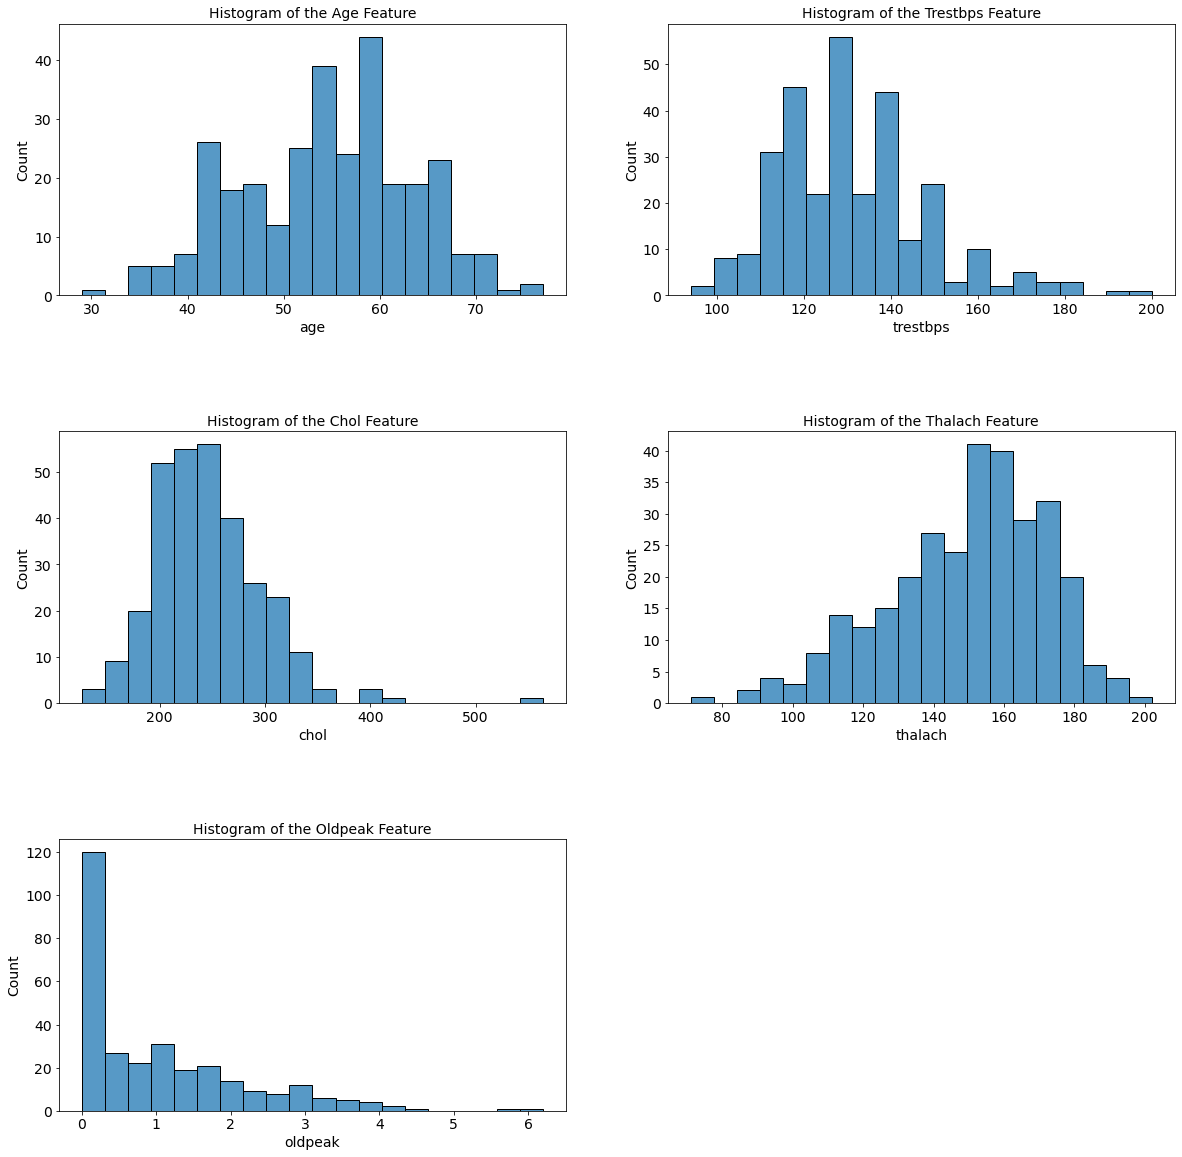

In [42]:
fig = plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(nrows=3, ncols=2)

for i, feature in enumerate(numerical_features):
    ax = fig.add_subplot(gs[i])
    sns.histplot(data=df[feature], bins=20, ax=ax)
    ax.set_title(f"Histogram of the {feature.capitalize()} Feature", )

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [43]:
continuous_distributions = [st.invgauss, st.geninvgauss, st.chi2, st.erlang, st.expon, st.norm, st.chi, st.lognorm, st.cauchy, st.gennorm, st.loguniform, st.uniform] # Some distributions we know

In [44]:
def best_distribution(df, features, distributions):
    best_distributions = dict()
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        for feature in features:
            try:
                neg_log_likelihoods = np.array([-np.log(distribution.pdf(df[feature], *distribution.fit(df[feature]))).sum() for distribution in distributions])
                min_index = np.argmin(neg_log_likelihoods)
                best_distributions[feature] = distributions[min_index]
            except:
                continue
    return best_distributions
     
distributions = best_distribution(df, numerical_features, continuous_distributions)


In [45]:
distributions

{'age': <scipy.stats._continuous_distns.gennorm_gen at 0x7fa1486a7160>,
 'trestbps': <scipy.stats._continuous_distns.lognorm_gen at 0x7fa14867b520>,
 'chol': <scipy.stats._continuous_distns.erlang_gen at 0x7fa14865b6d0>,
 'thalach': <scipy.stats._continuous_distns.gennorm_gen at 0x7fa1486a7160>,
 'oldpeak': <scipy.stats._continuous_distns.chi_gen at 0x7fa139f5b460>}

<div class="alert alert-info">
We are very lucky to discover that distplot has been deprecated and that seaborn resents plotting with matplotlib in one axis so we are going to make less attractive charts</div>

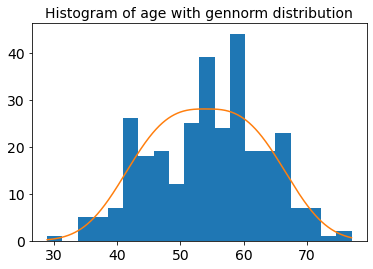

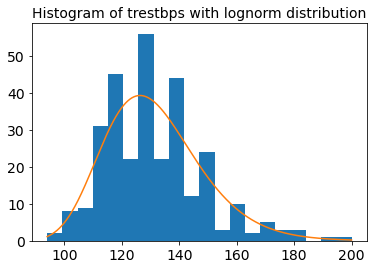

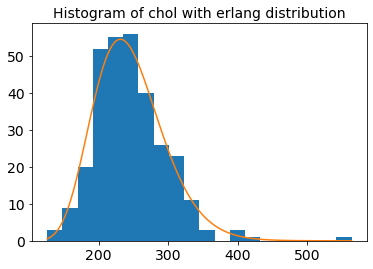

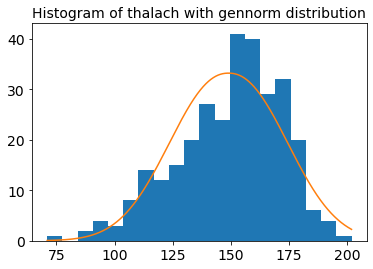

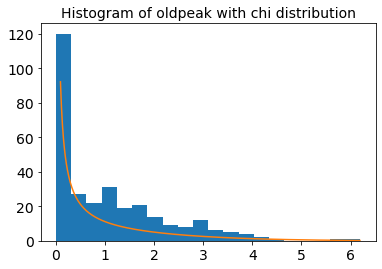

In [46]:
for feature in numerical_features:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        plt.title(f"Histogram of {feature} with {distributions[feature].name} distribution")
        x_axis = np.arange(df[feature].min(), df[feature].max(), 0.01)
        bin_edges = plt.hist(df[feature], bins=20)[1]
        dist = distributions[feature].pdf(x_axis, *distributions[feature].fit(df[feature]))
        plt.plot(x_axis[dist < 1], len(df) * (bin_edges[1] - bin_edges[0]) * dist[dist < 1])
    plt.show()

For each pair of numerical feature, calculate correlations and indicate whether you find them significant. For select pairs, with significant correlations, draw joint plot with marginal histograms (see Seaborn joint plot) and find bivariate normal fits. Then use the example code below to draw plots of the bivariate pdfs (you may edit the code as you see fit).

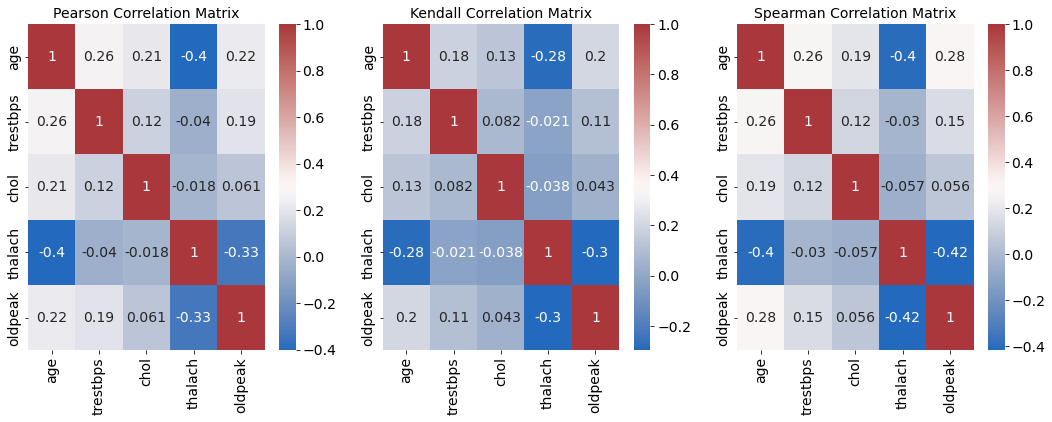

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
corr_methods = ['pearson', 'kendall', 'spearman']
for i, method in enumerate(corr_methods):
    corr_matrix = df[numerical_features].corr(method)
    sns.heatmap(corr_matrix, annot=True, cmap='vlag', ax=ax[i])
    ax[i].set_title(f"{method.capitalize()} Correlation Matrix")
plt.show()

<div class="alert alert-info">
We can see that we do not have very strongly correlated features but we have some that have a nice correlation nonetheless. Let's select .35 as our threshold and identify a few pairs. It is hard to determine visually a strong correlation this way.</div>

In [48]:
strong_corr = set()
for method in corr_methods:
    correlation = df[numerical_features].corr(method)
    strong = correlation[abs(correlation) >= 0.35].stack().reset_index()
    strong.columns = ['feature1', 'feature2', 'correlation']
    strong = strong[strong.feature1 != strong.feature2]
    for feature1, feature2 in strong[['feature1', 'feature2']].values:
        if feature1 < feature2: strong_corr.add((feature1, feature2))

print(f'Strong correlation pairs: {strong_corr}')

Strong correlation pairs: {('age', 'thalach'), ('oldpeak', 'thalach')}


<div class="alert alert-info">
I have edited your 2d gaussion pdf function and use a custom class to move the joint plot which isn't partial to being in a grid.    </div>

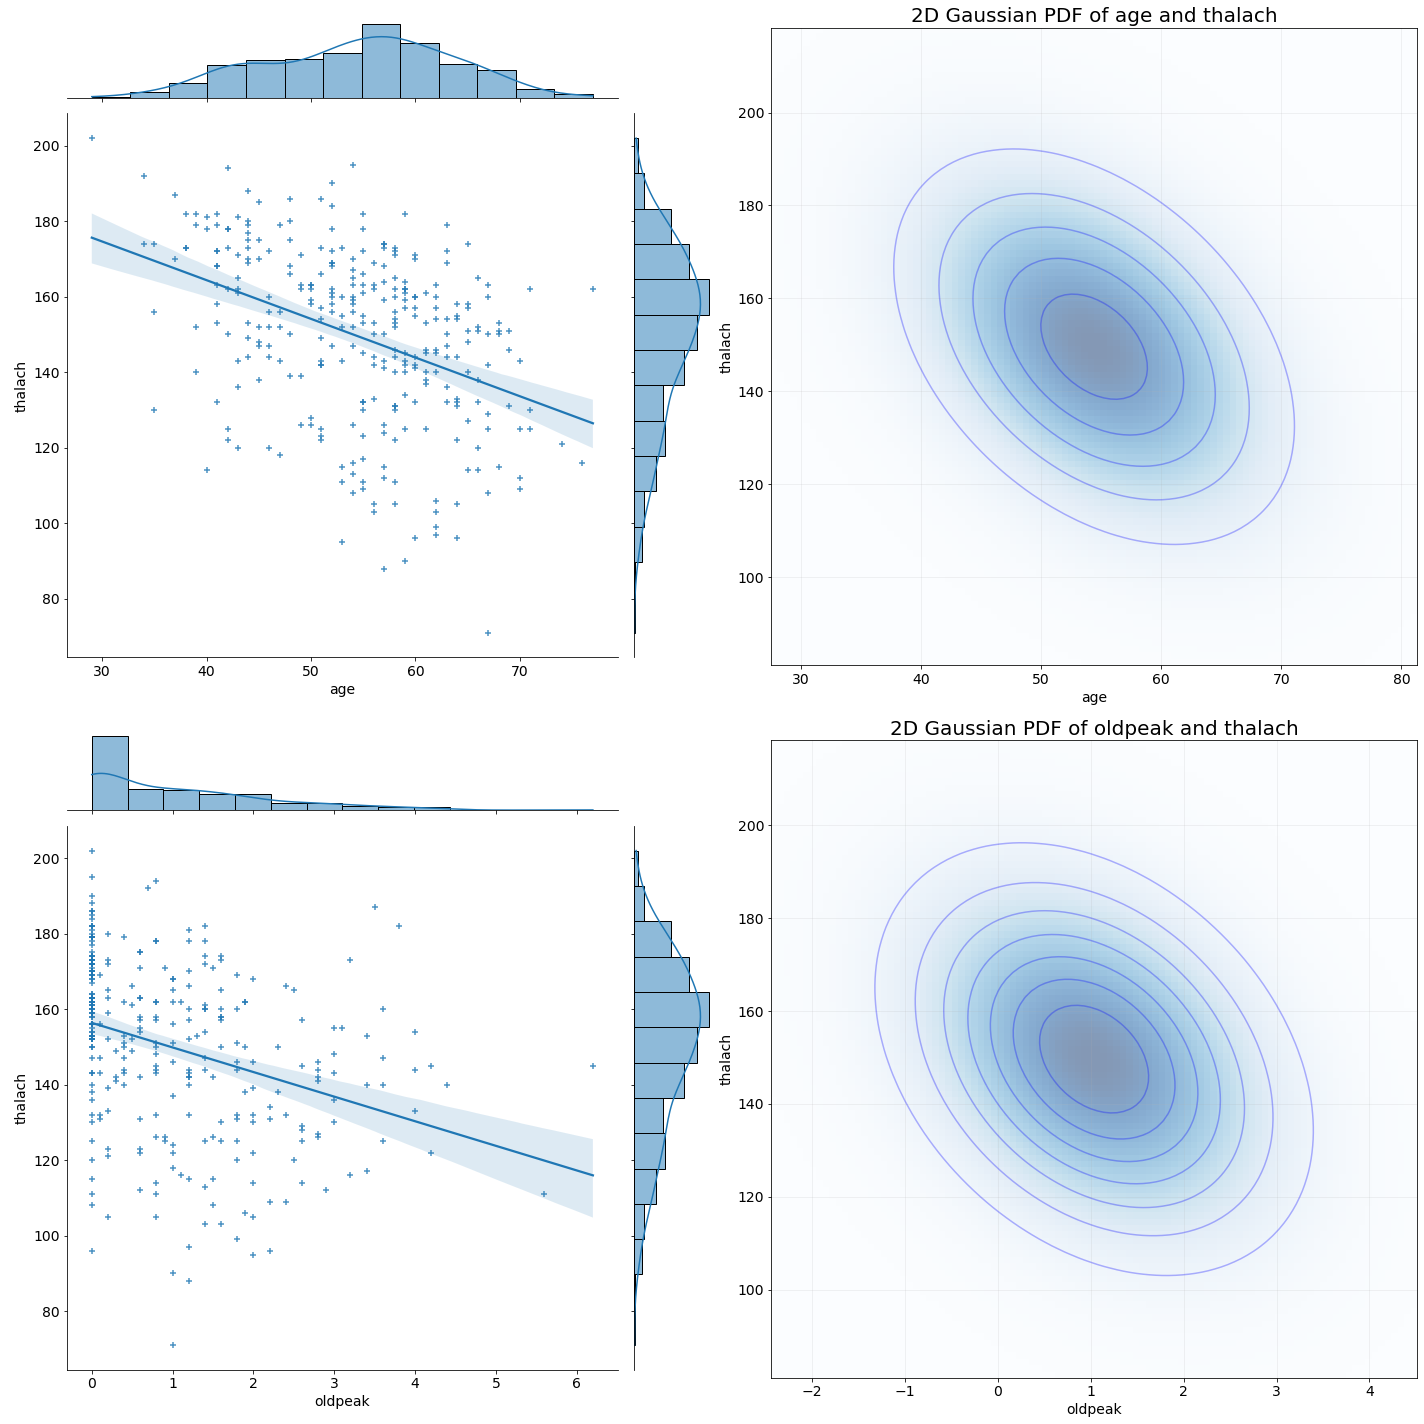

In [49]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(2, 2)

for i, (feature_1, feature_2) in enumerate(strong_corr):
    ax0 = PlotMover(sns.jointplot(x=feature_1, y=feature_2, data=df, kind='reg', marker='+'), fig, gs[i*2])
    features = df[[feature_1, feature_2]]
    mean, cov = np.mean(features, axis=0), np.cov(features.T)
    ax1 = plot_2d_Gaussian_pdf(mean, cov, ax=gs[i*2+1])
    ax1.set_title(f"2D Gaussian PDF of {feature_1} and {feature_2}", fontsize=20)
    ax1.set_xlabel(feature_1)
    ax1.set_ylabel(feature_2)

gs.tight_layout(fig)
plt.show()

Are there pairs that are significantly correlated in males but not in females? The opposite? How about healthy vs disease? Can you graphically represent this?

<div class="alert alert-info">
Let's look at the correlations between men and women</div>

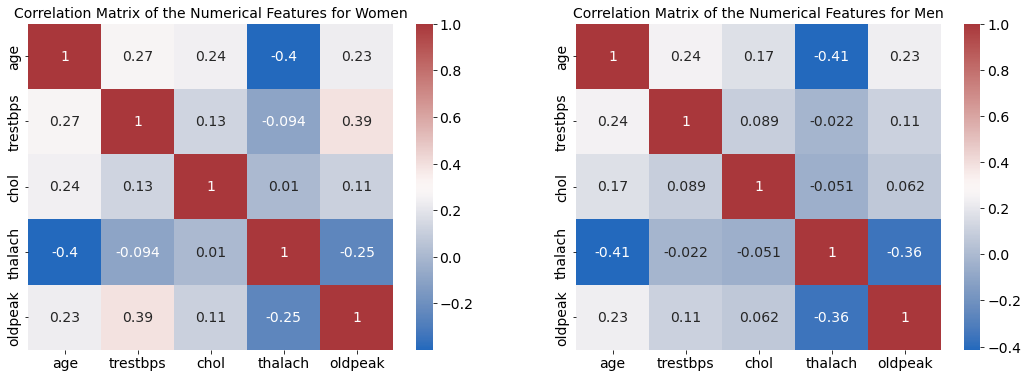

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
titles = ["Correlation Matrix of the Numerical Features for Women", "Correlation Matrix of the Numerical Features for Men"]
for i, sex in enumerate(["F", "M"]):
    sns.heatmap(df[(df['sex'] == sex)][numerical_features].corr(), ax=ax[i], annot=True, cmap='vlag')
    ax[i].set_title(titles[i])
plt.show()

<div class="alert alert-info">
And healthy and disease populations</div>

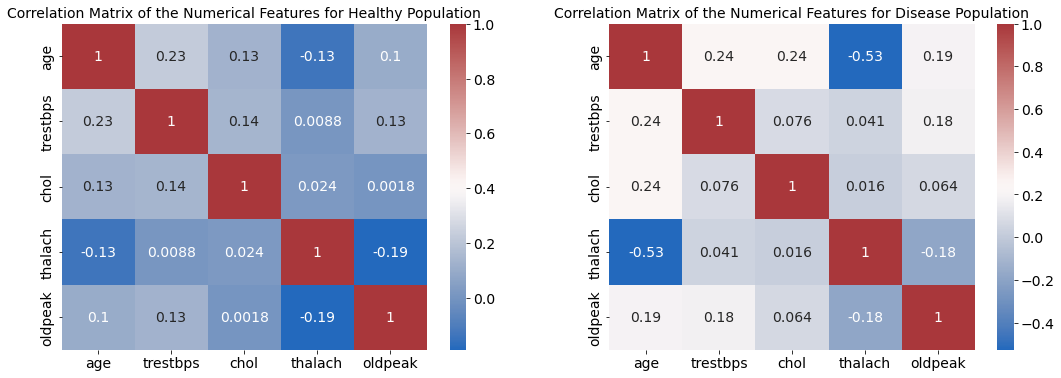

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
titles = ["Correlation Matrix of the Numerical Features for Healthy Population", "Correlation Matrix of the Numerical Features for Disease Population"]
for i, target in enumerate(["healthy", "disease"]):
    sns.heatmap(df[(df['target'] == target)][numerical_features].corr(), ax=ax[i], annot=True, cmap='vlag')
    ax[i].set_title(titles[i])
plt.show()

<div class="alert alert-info">
Let's write code that finds correlations that differ between two populations we are interested in:</div>

In [52]:
def significant_correlations_function(one, two, threshold=0.35, diff=0.2):
    correlations = {}
    for feature_1, feature_2 in combinations(numerical_features, 2):
        partition_one = st.pearsonr(one[feature_1], one[feature_2])
        partition_two = st.pearsonr(two[feature_1], two[feature_2])
        if diff < abs(partition_one[0] - partition_two[0]) < 1 + diff and any(map(lambda x: abs(x) > threshold, [partition_one[0], partition_two[0]])):
            correlations[(feature_1, feature_2)] = (partition_one, partition_two)
    return correlations

In [53]:
males = df[df['sex'] == "M"]
females = df[df['sex'] == "F"]

significant_correlations = significant_correlations_function(males, females, threshold=0.35, diff = 0.25 )
male_p = list(significant_correlations.values())[0][1][1]
female_p = list(significant_correlations.values())[0][0][1]

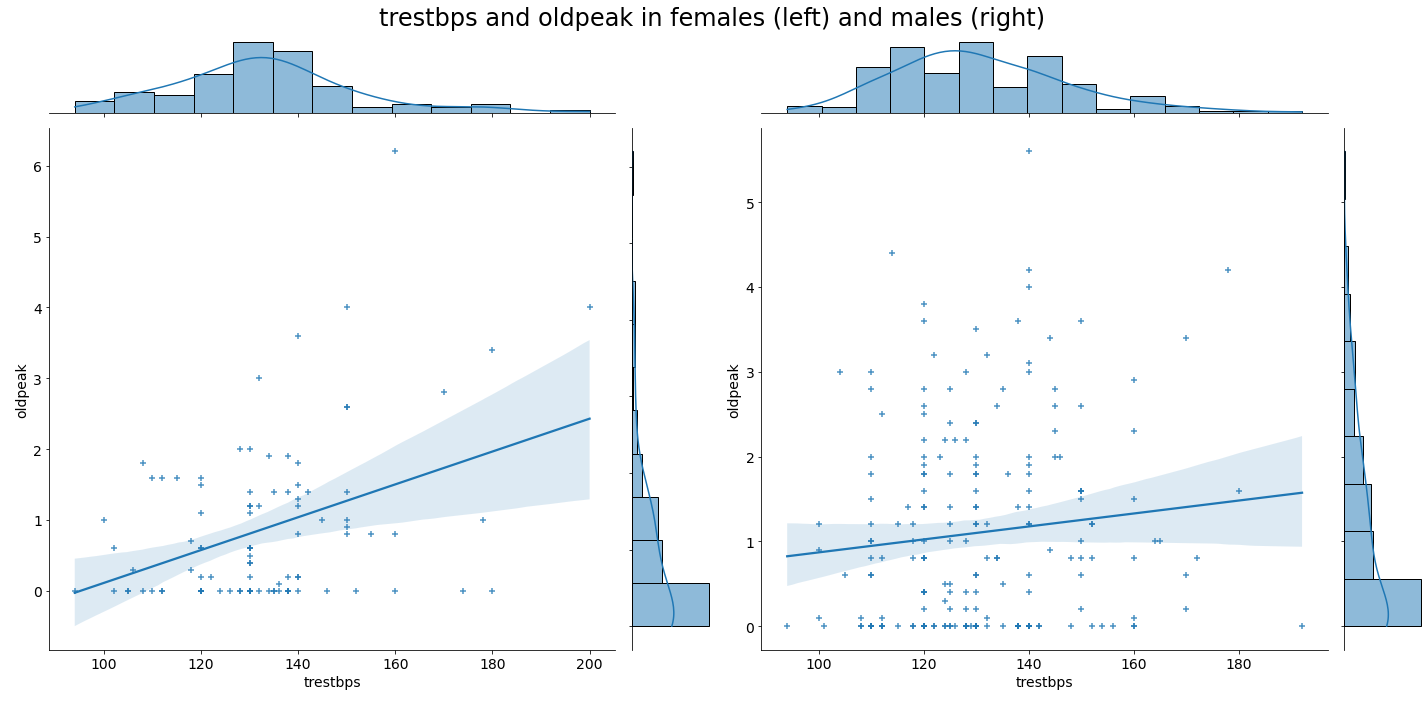

trestbps and oldpeak in female population has a p-value of 0.11819177735866322
trestbps and oldpeak in male population has a p-value of 9.572956503027135e-05


In [54]:
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(1, 2)

for pair in significant_correlations:
    ax_female = sns.jointplot(x=females[pair[0]], y=females[pair[1]], kind='reg', marker='+')
    ax_male = sns.jointplot(x=males[pair[0]], y=males[pair[1]], kind='reg', marker='+')
    plot_mover = PlotMover(ax_female, fig, gs[0])
    plot_mover = PlotMover(ax_male, fig, gs[1])

fig.suptitle(f'{pair[0]} and {pair[1]} in females (left) and males (right)', size=24)
gs.tight_layout(fig)
plt.show()

print(f"{pair[0]} and {pair[1]} in female population has a p-value of {female_p}")
print(f"{pair[0]} and {pair[1]} in male population has a p-value of {male_p}")

<div class="alert alert-info">
We can see that the correlation between oldpeak and trestbps is significant in males, but not in females.
    </div>

In [55]:
healthy = df[df['target'] == "healthy"]
disease = df[df['target'] == "disease"]

significant_correlations_disease = significant_correlations_function(disease, healthy, threshold=0.35, diff = 0.25 )
healthy_p = list(significant_correlations_disease.values())[0][1][1]
disease_p = list(significant_correlations_disease.values())[0][0][1]

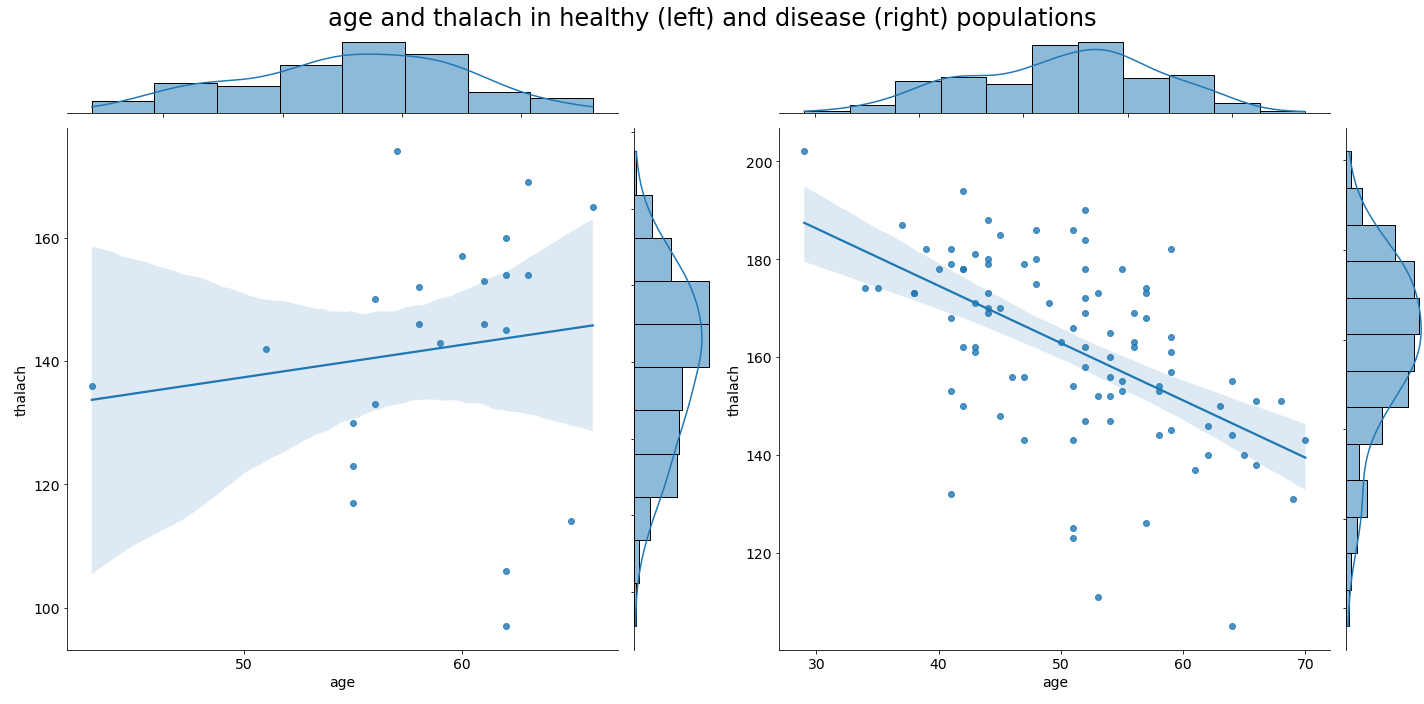

age and thalach in healthy population has a p-value of 0.11611039893368287
age and thalach in disease population has a p-value of 3.3295645376688044e-13


In [56]:
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(1, 2)

for pair in significant_correlations_disease:
    ax_healthy = sns.jointplot(x=females[pair[0]], y=healthy[pair[1]], kind='reg')
    ax_disease = sns.jointplot(x=males[pair[0]], y=disease[pair[1]], kind='reg')
    plot_mover = PlotMover(ax_healthy, fig, gs[0])
    plot_mover = PlotMover(ax_disease, fig, gs[1])

fig.suptitle(f'{pair[0]} and {pair[1]} in healthy (left) and disease (right) populations', size=24)
gs.tight_layout(fig)
plt.show()

print(f"{pair[0]} and {pair[1]} in healthy population has a p-value of {healthy_p}")
print(f"{pair[0]} and {pair[1]} in disease population has a p-value of {disease_p}")

<div class="alert alert-info">
We can see that the correlation between age and thalach is not significant in healthy populations, but is in unhealthy people.
    </div>

For each numerical feature, except age, plot the distribution for this feature against bins of age. In each bin provide a split violin plot, with different colors for healthy and disease.

In [57]:
stats = df.describe()

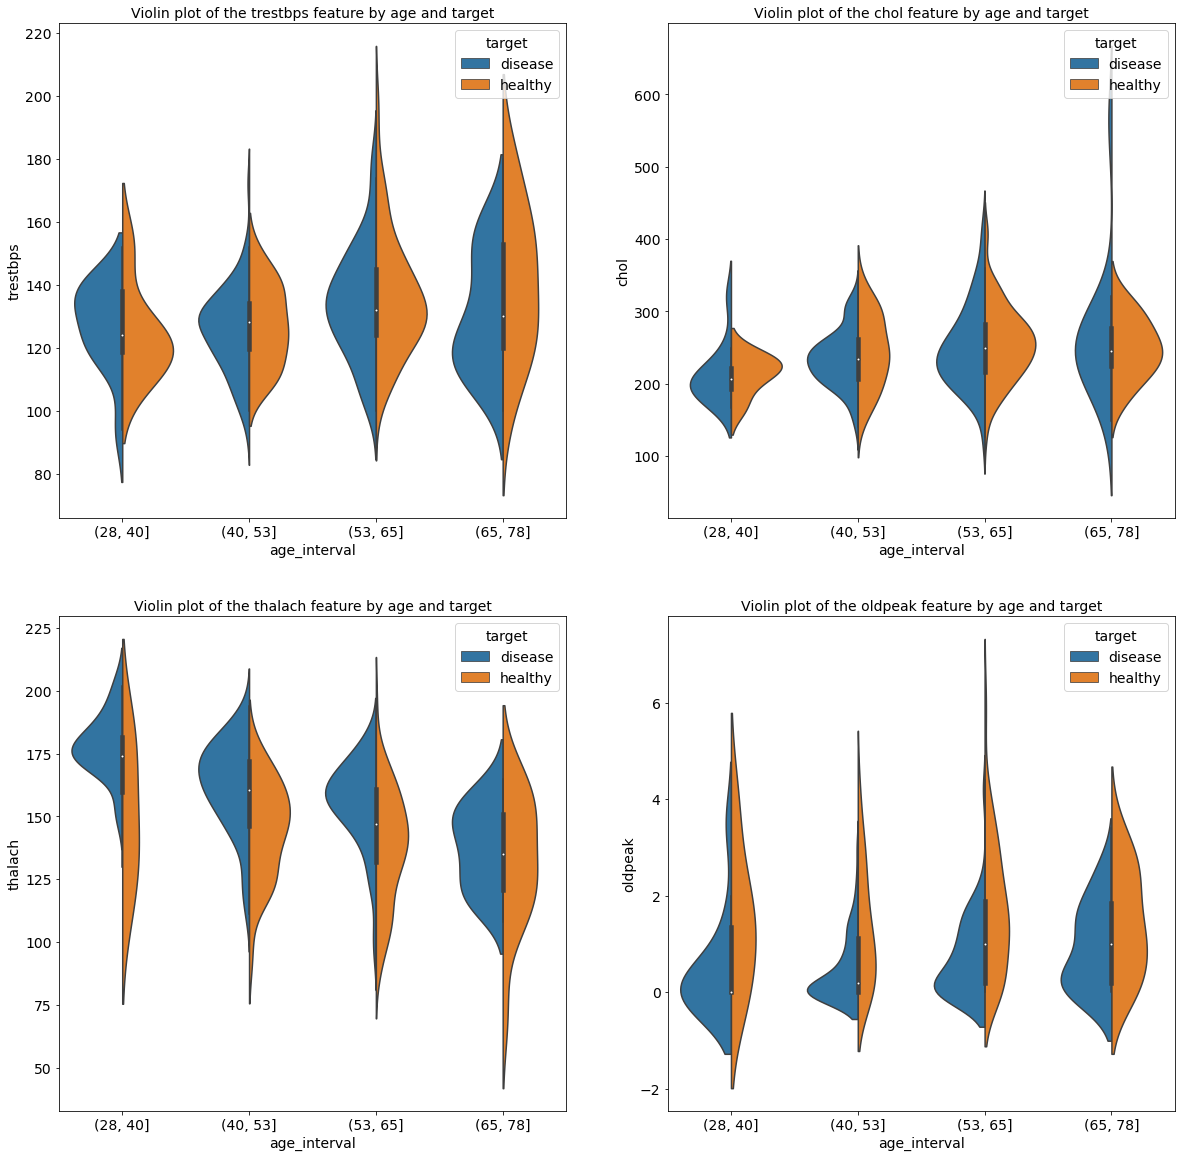

<Figure size 1440x720 with 0 Axes>

In [58]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
plt.figure(figsize=(20,10))
violin = df[numerical_features + ['target']]
bins = np.linspace(stats.age['min'] - 1, stats.age['max'] + 1, 5, dtype = int)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    violin['age_interval'] = pd.cut(x=df.age, bins=bins)
axes = axes.flatten()
i = 0
for feature in numerical_features:
        if feature == 'age':
            continue
        ax = sns.violinplot(x='age_interval', y=feature, data=violin, hue='target', split=True, ax=axes[i])
        ax.set_title(f'Violin plot of the {feature} feature by age and target')
        i += 1

plt.show()

Suggest, state and address at least one original question.

<div class="alert alert-info">
We didn't observe very many strong correlations in our exploratory data analysis up until now, so I suggest a study that observes how age influence outcomes and to see if maybe for our data we can identify something that could train a model. Let's see first if there is a relationship to age and sex:</div>

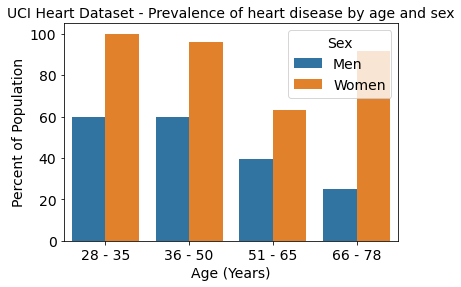

In [59]:
ranges = [(28, 35), (36, 50), (51, 65), (66,78)]
df_age = pd.DataFrame(columns=['Age Range', 'Sex', 'Percent of Population'])

for group in ranges:
    age_range = df.loc[(df['age'] >= group[0]) & (df['age'] <= group[1])]
    men_percent = age_range[(age_range['sex']=="M") & (age_range['target']=="disease")].shape[0] / age_range[age_range['sex']=="M"].shape[0] * 100 if age_range[age_range['sex']=="M"].shape[0] else np.nan
    women_percent = age_range[(age_range['sex']=="F") & (age_range['target']=="disease")].shape[0] / age_range[age_range['sex']=="F"].shape[0] * 100 if age_range[age_range['sex']=="F"].shape[0] else np.nan
    
    df_age = df_age.append({'Age Range': f"{group[0]} - {group[1]}", 'Sex': 'Men', 'Percent of Population': men_percent}, ignore_index=True)
    df_age = df_age.append({'Age Range': f"{group[0]} - {group[1]}", 'Sex': 'Women', 'Percent of Population': women_percent}, ignore_index=True)

sns.barplot(x="Age Range", y="Percent of Population", hue="Sex", data=df_age)
plt.title('UCI Heart Dataset - Prevalence of heart disease by age and sex')
plt.xlabel('Age (Years)')
plt.ylabel('Percent of Population');

<div class="alert alert-info">
We have a suprising result here! I didn't expect that such high percentages of women would have heart disease. Let's try to get intuition about this and calculate how many women there are in the dataset, compared to men.</div>

In [60]:
sex_counts = df['sex'].value_counts()
women_count = sex_counts['F']
men_count = sex_counts['M']
total_count = women_count + men_count
print(f"Proportion of women in dataset: {women_count / total_count}")

Proportion of women in dataset: 0.31353135313531355


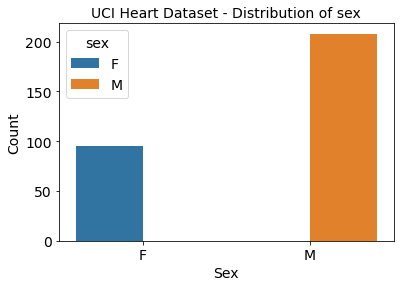

In [61]:
sns.countplot(x="sex", data=df, hue="sex")
plt.title("UCI Heart Dataset - Distribution of sex")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()

In [62]:
ranges = [(28, 35), (36, 50), (51, 65), (66,78)]

healthy_women, disease_women , all_women = [], [], []

for group in ranges:
    age_range = df.loc[(df['age'] >= group[0]) & (df['age'] <= group[1]) & (df['sex']=="F")]
    grouped = age_range.groupby('target').size()
    healthy_women.append(grouped['healthy'] if 'healthy' in grouped else np.nan)
    disease_women.append(grouped['disease'] if 'disease' in grouped else np.nan)

for i, group in enumerate(ranges):
    print(f"For age range {group}, {healthy_women[i]} women are healthy and {disease_women[i]} have heart disease")

For age range (28, 35), 0 women are healthy and 1 have heart disease
For age range (36, 50), 1 women are healthy and 24 have heart disease
For age range (51, 65), 21 women are healthy and 36 have heart disease
For age range (66, 78), 1 women are healthy and 11 have heart disease


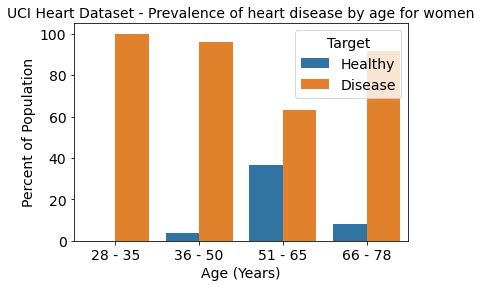

In [63]:
ranges = [(28, 35), (36, 50), (51, 65), (66,78)]
df_age = pd.DataFrame(columns=['Age Range', 'Target', 'Percent of Population'])

for group in ranges:
    age_range = df.loc[(df['age'] >= group[0]) & (df['age'] <= group[1]) & (df['sex']=="F")]
    healthy_percent = age_range[(age_range['target']=="healthy")].shape[0] / age_range.shape[0] * 100 if age_range.shape[0] else np.nan
    disease_percent = age_range[(age_range['target']=="disease")].shape[0] / age_range.shape[0] * 100 if age_range.shape[0] else np.nan
    
    df_age = df_age.append({'Age Range': f"{group[0]} - {group[1]}", 'Target': 'Healthy', 'Percent of Population': healthy_percent}, ignore_index=True)
    df_age = df_age.append({'Age Range': f"{group[0]} - {group[1]}", 'Target': 'Disease', 'Percent of Population': disease_percent}, ignore_index=True)

sns.barplot(x="Age Range", y="Percent of Population", hue="Target", data=df_age)
plt.title('UCI Heart Dataset - Prevalence of heart disease by age for women')
plt.xlabel('Age (Years)')
plt.ylabel('Percent of Population');


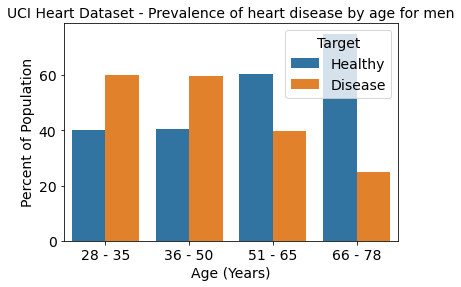

In [64]:
ranges = [(28, 35), (36, 50), (51, 65), (66,78)]
df_age = pd.DataFrame(columns=['Age Range', 'Target', 'Percent of Population'])

for group in ranges:
    age_range = df.loc[(df['age'] >= group[0]) & (df['age'] <= group[1]) & (df['sex']=="M")]
    healthy_percent = age_range[(age_range['target']=="healthy")].shape[0] / age_range.shape[0] * 100 if age_range.shape[0] else np.nan
    disease_percent = age_range[(age_range['target']=="disease")].shape[0] / age_range.shape[0] * 100 if age_range.shape[0] else np.nan
    
    df_age = df_age.append({'Age Range': f"{group[0]} - {group[1]}", 'Target': 'Healthy', 'Percent of Population': healthy_percent}, ignore_index=True)
    df_age = df_age.append({'Age Range': f"{group[0]} - {group[1]}", 'Target': 'Disease', 'Percent of Population': disease_percent}, ignore_index=True)

sns.barplot(x="Age Range", y="Percent of Population", hue="Target", data=df_age)
plt.title('UCI Heart Dataset - Prevalence of heart disease by age for men')
plt.xlabel('Age (Years)')
plt.ylabel('Percent of Population');

<div class="alert alert-info">
It looks like this data isn't very representative... if this was indicative of general trends then all my female friends and I have heart disease at our age range! Let's try to use some of our findings before about diseased populations and age splits.</div>

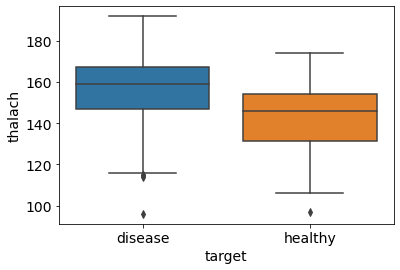

In [65]:
sns.boxplot(x='target', y='thalach', data=df[df['sex']=='F'],);

<div class="alert alert-info">
Let's continue to explore thalach and its relationship to age here since we saw it had some relationship to being ill. Since we have very high percentage of disease in our younger female populations, let's look at a split.</div>

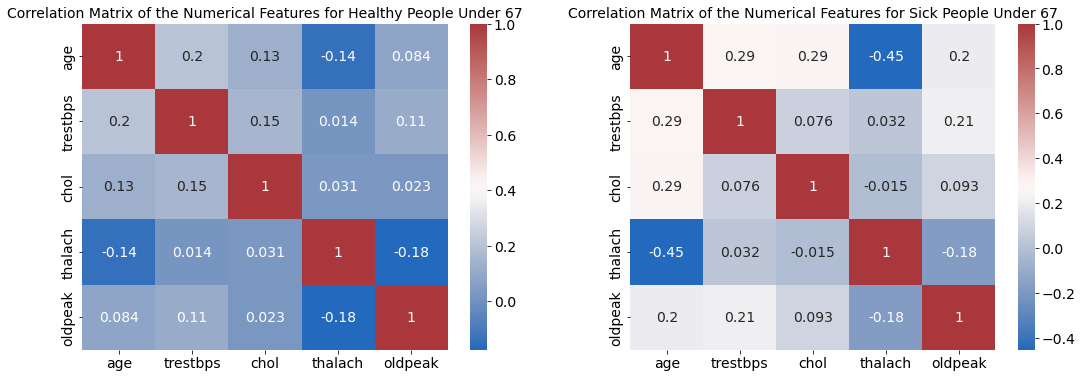

In [66]:
under_67 = df[df['age']<=67]

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
titles = ["Correlation Matrix of the Numerical Features for Healthy People Under 67", "Correlation Matrix of the Numerical Features for Sick People Under 67"]
for i, target in enumerate(["healthy", "disease"]):
    sns.heatmap(under_67[(under_67['target'] == target)][numerical_features].corr(), ax=ax[i], annot=True, cmap='vlag')
    ax[i].set_title(titles[i])
plt.show()

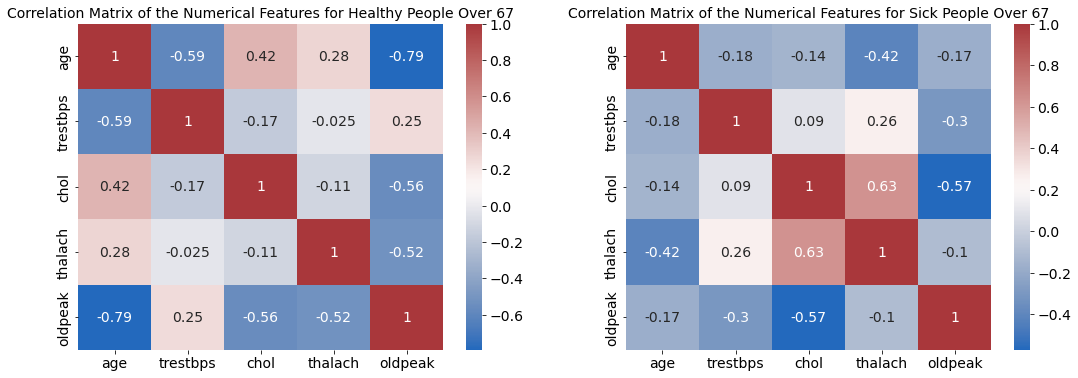

In [67]:
over_67 = df[df['age']>67]

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
titles = ["Correlation Matrix of the Numerical Features for Healthy People Over 67", "Correlation Matrix of the Numerical Features for Sick People Over 67"]
for i, target in enumerate(["healthy", "disease"]):
    sns.heatmap(over_67[(over_67['target'] == target)][numerical_features].corr(), ax=ax[i], annot=True, cmap='vlag')
    ax[i].set_title(titles[i])
plt.show()

<div class="alert alert-info">
Let's continue to explore thalach and its relationship to age here, we know from before that thalach is more common in the sick, but also more common in men. Since we have very high percentage of disease in our younger female populations, let's look at a split to see if we have any numbers which may indicate it.</div>

In [68]:
healthy_over_67 = over_67[over_67['target']=='healthy']
sick_over_67 = over_67[over_67['target']=='disease']
significant_correlations = significant_correlations_function(healthy_over_67, sick_over_67 ,threshold=0.35, diff = 0.25 )

In [69]:
significant_correlations

{('age', 'trestbps'): ((-0.5934511596867218, 0.16012182777605977),
  (-0.1753789063471547, 0.6279424222122569)),
 ('age', 'chol'): ((0.4232988119353852, 0.34399756619099175),
  (-0.14214760500492082, 0.6952593030428061)),
 ('age', 'thalach'): ((0.27657092738514844, 0.5482278483342049),
  (-0.4172930728549143, 0.23020646840256595)),
 ('age', 'oldpeak'): ((-0.7921388314151254, 0.03370779988796852),
  (-0.17493828144796325, 0.6288202672977785)),
 ('chol', 'thalach'): ((-0.11293056380710825, 0.809503290855362),
  (0.6265816770359003, 0.05256277626691969)),
 ('thalach', 'oldpeak'): ((-0.5235107835292543, 0.22786139036720773),
  (-0.10200536205754393, 0.7791705701593293))}

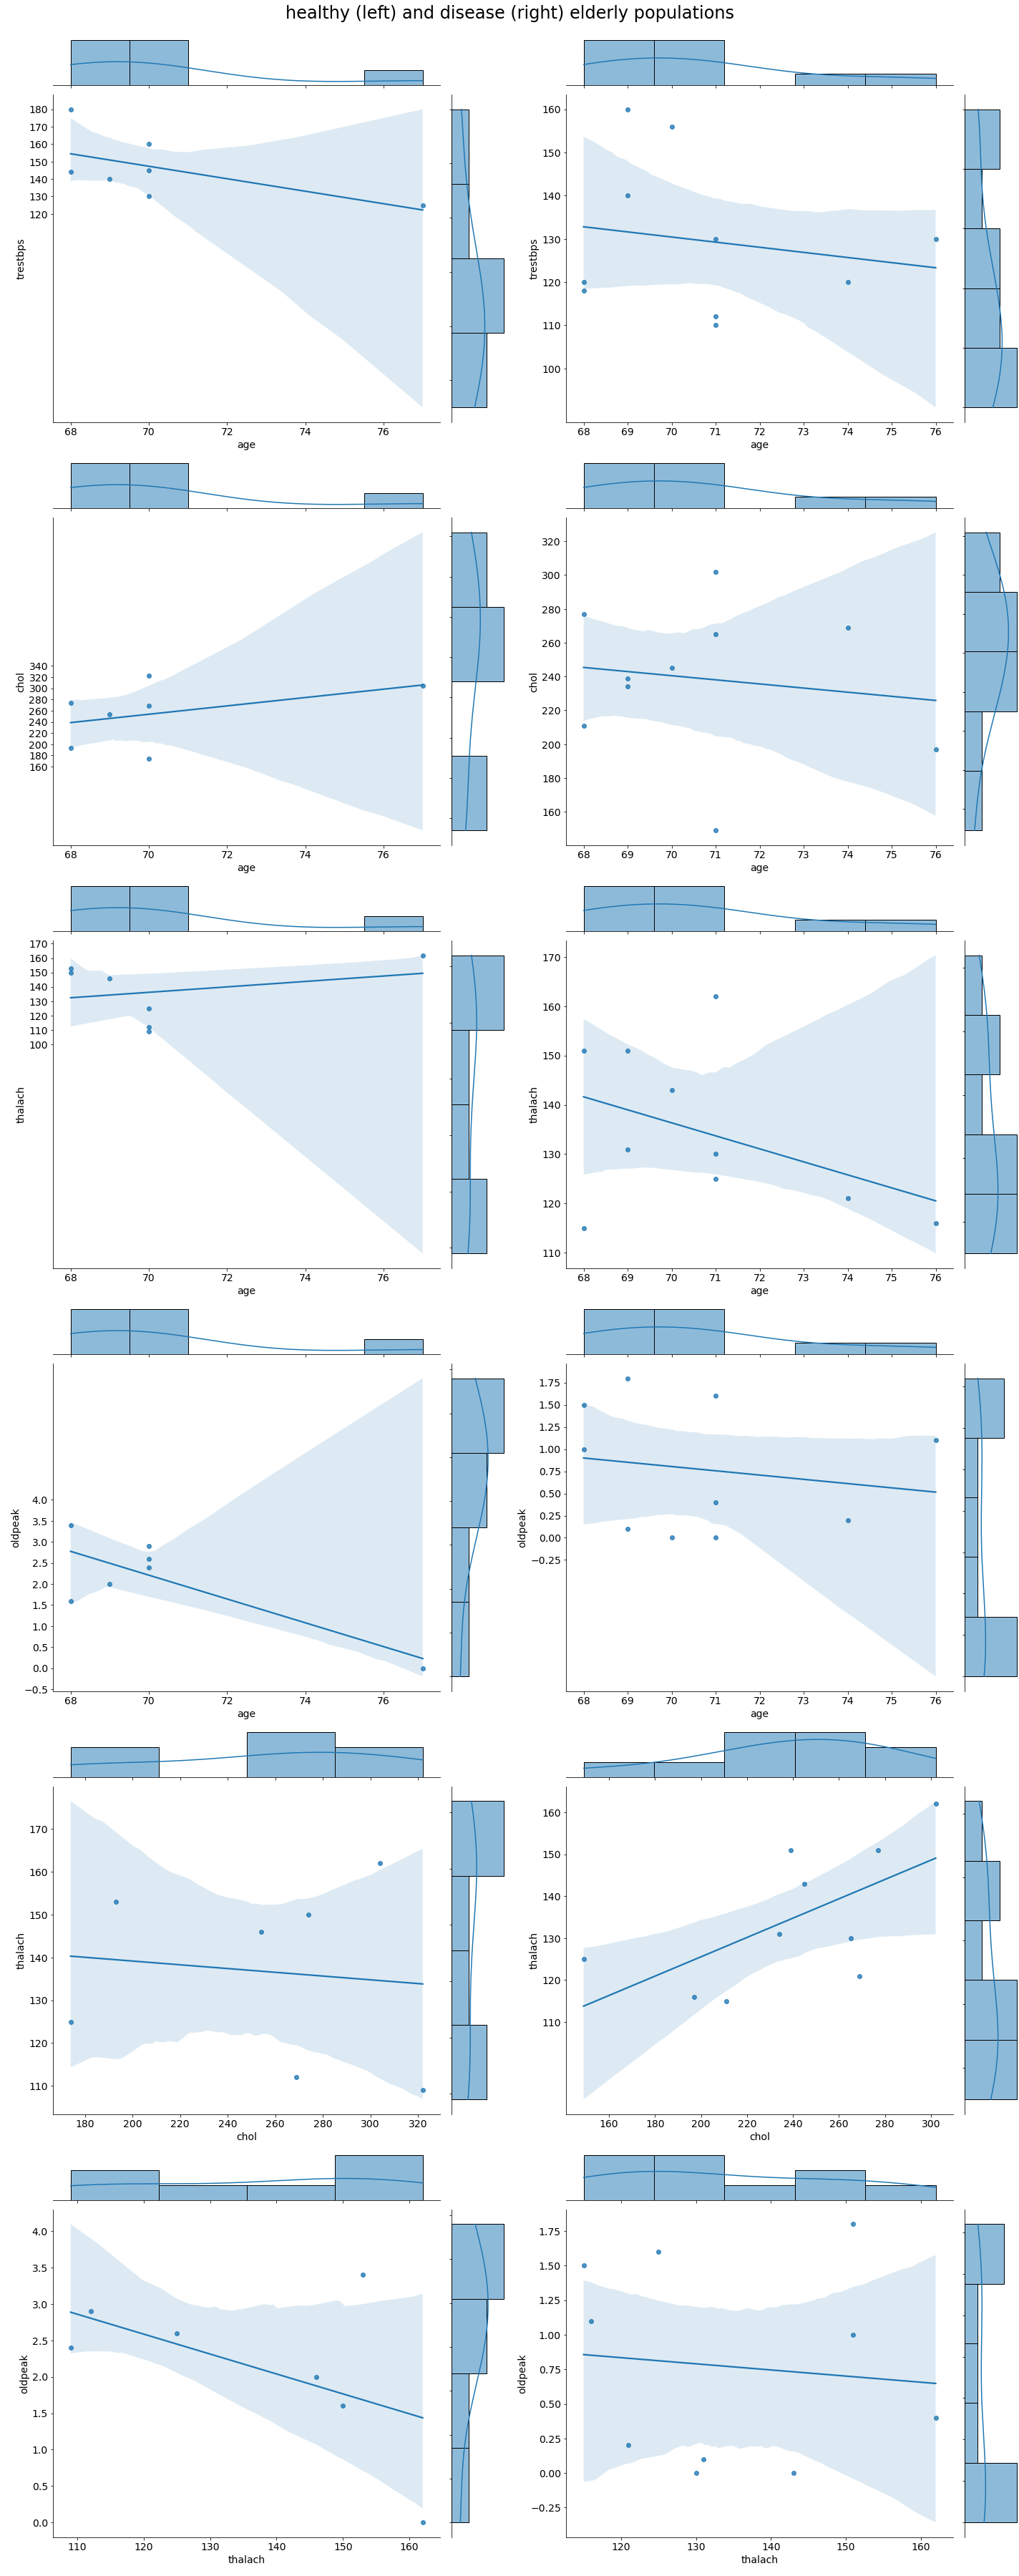

In [70]:
fig = plt.figure(figsize=(20, 50))
gs = gridspec.GridSpec(6, 2)
for i, pair in enumerate(significant_correlations):
    ax_healthy = sns.jointplot(x=healthy_over_67[pair[0]], y=healthy_over_67[pair[1]], kind='reg')
    ax_disease = sns.jointplot(x=sick_over_67[pair[0]], y=sick_over_67[pair[1]], kind='reg')
    plot_mover = PlotMover(ax_healthy, fig, gs[i*2])
    plot_mover = PlotMover(ax_disease, fig, gs[i*2+1])
    
fig.suptitle(f'healthy (left) and disease (right) elderly populations', size=24, y=1.0)
gs.tight_layout(fig)
plt.show()

<div class="alert alert-info">
We can see a stronger relationship here, we have age and oldpeak together, which we saw earlier are negatively correlated and have a p value which allows us to reject our null hypothesis. This shows that healthier populations (in the test) will be less likely to be ill.</div>

<div class="alert alert-info">
Let's add something we know from common sense that may not be represented in these charts, if you can't see major vessels they may be too small to fluoresce and this may be a sign of disease. Maybe we have a relationship to age here too, or gender:</div>

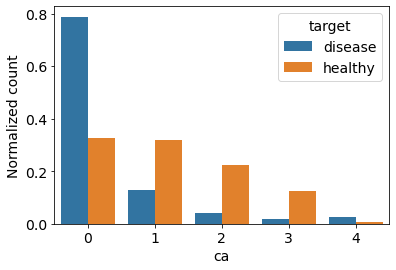

In [71]:
x = 'ca'
hue='target'
y='Normalized count'
normalized_counts = df[x].groupby(df[hue]).value_counts(normalize=True).rename(y).reset_index()
sns.barplot(data=normalized_counts, x=x, y=y, hue=hue);

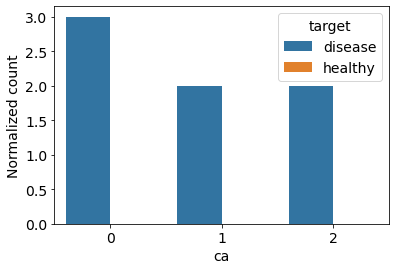

In [72]:
filtered_df = over_67[over_67["sex"] == "F"]
grouped_df = filtered_df.groupby(["ca", "target"]).size().reset_index(name="Normalized count")
sns.barplot(x="ca", y="Normalized count", hue="target", data=grouped_df);

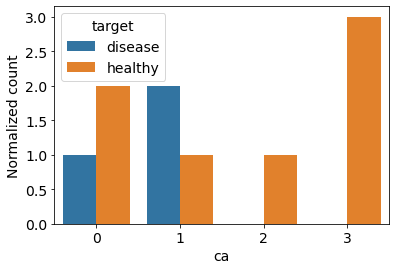

In [73]:
filtered_df = over_67[over_67["sex"] == "M"]
grouped_df = filtered_df.groupby(["ca", "target"]).size().reset_index(name="Normalized count")
sns.barplot(x="ca", y="Normalized count", hue="target", data=grouped_df);

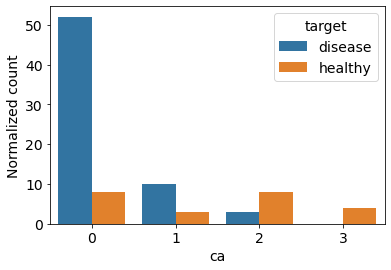

In [74]:
filtered_df = under_67[under_67["sex"] == "F"]
grouped_df = filtered_df.groupby(["ca", "target"]).size().reset_index(name="Normalized count")
sns.barplot(x="ca", y="Normalized count", hue="target", data=grouped_df);

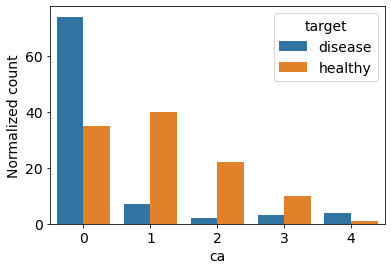

In [75]:
filtered_df = under_67[under_67["sex"] == "M"]
grouped_df = filtered_df.groupby(["ca", "target"]).size().reset_index(name="Normalized count")
sns.barplot(x="ca", y="Normalized count", hue="target", data=grouped_df);

<div class="alert alert-info">
It looks like at least for this data, this is a great indicator of illness and could be used as a classifier. We know from our previous data analysis that if we want to classify then age and sex won't be good because the data is highly biased. We saw that many younger patients are sick, but don't necessarily have the characteristics we associate with heart disease, and that the gender split is also skewed. If anything, we should be looking at a larger data set and using it to determine whether our data is consistent with it/representative. </div>

### Question 3 - Heavy Tailed Distributions and the Exponential Distribution (16 points)

### Heavy Tailed Distributions

Recall the definition of Heavy Tailed distribution from the lectures.

*A distribution is said to have a heavy right tail if its tail probabilities vanish slower than any exponential*
$$ \forall t>0, \lim_{x\to\infty} e^{tx}P(X>x)=\infty $$

Does the standard log-normal distribution have a heavy right tail? prove your answer.

<div class="alert alert-info">
Variable $X$ has (standard) log-normal distribution if it's logarithm $Z=\ln X$ is distributed according to the standard normal. For the cumulative probabilities we obtain:
    
$P(X > x) = P(e^Z > x) = P(Z > \ln x) = 1 - P(Z \leq \ln x) = 1-F_Z(\ln x)$
    
where $F_Z(z)$ is the CDF of the standard normal. We can further write
    
$F_Z(z) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^z e^{-u^2/2} du = \frac{1}{2} + \frac{1}{\sqrt{\pi}} \int_0^{z/\sqrt{2}} e^{-v^2} dv = \frac{1}{2} (1 + {\tt erf}(z/\sqrt{2}))$
    
where the last integral was replaced (by definition) by the error function. Hence, after substituting the last expression into the first one, for $P(X > x)$ we now obtain:
    
$P(X>x) = \frac{1}{2} (1 - {\tt erf}(\ln x/\sqrt{2}))$.
    
Since we are interested in the limit $x\rightarrow \infty$, we can use the asymptotic expansion of the error function:

${\tt erf z} \approx 1 - \frac{e^{-z^2}}{\sqrt{\pi} z}$
    
which in our case leads to:
    
$P(X>x) \approx \frac{e^{-(\ln^2 x)/2}}{\sqrt{2\pi} \ln x}$ (when $x\rightarrow \infty$)    
  
It is now easy to see that if the last expression is multiplied by $e^{tx}$ then the limit of the product will be $\infty$ as $x\rightarrow \infty$ because we will have $e^{tx - (\ln^2 x)/2}$, and as $x$ grows faster than $\ln x$ (or $\ln^2 x$), the exponent will diverge (and exponential divergence is also faster than the $\ln x$ in the denominator of the above expression for $P(X>x)$, so the latter still diverges).
    
Hence, yes, log-normal distribution does have heavy tails.
    
</div>

### Special Properties of the Exponential Distribution

Let $X_1 \sim exp(\lambda_1)$ and $X_2 \sim exp(\lambda_2)$ be two independent exponential random variables.

Calculate $P(X_1 < X_2)$.

<div class="alert alert-info">

Let us consider conditional probability (density) $P(X_2 > X_1 | X_1 = x) = P(X_2 > x | X_1 = x)$. But since the varoiables $X_1$, $X_2$ are independent, the latter probability is simply equal to $P(X_2 > x)=1-F_{X_2}(x)$, where $F_{X_2}(x)$ is the CDF of the exponential variable $X_2$, i.e. $1 - e^{-\lambda_2 x}$. Combining these statements we obtain:
    
$ P(X_2 > X_1 | X_1 = x ) = e^{-\lambda_2 x}$. But then the joint probability density becomes
    
$ P(X_2 > X_1 ,  X_1 = x) = P(X_2 > X_1 | X_1 = x ) P(X_1=x) =  e^{-\lambda_2 x}  f_{X_1}(x) =  e^{-\lambda_2 x} \lambda_1 e^{-\lambda_1 x}$. We need to integrate out the event $X_1=x$ from the joint probability so that we will be left with the marginal $P(X_2 > X_1)$:
    
$P(X_2 > X_1) = \int_0^\infty P(X_2 > X_1 ,  X_1 = x) dx = \int_0^\infty  \lambda_1 e^{-(\lambda_1+\lambda_2) x} dx = \frac{\lambda_1}{\lambda_1+\lambda_2} $.
    
Alternatively, this can be shown by using the fact that the difference of two exponential variables $Z=X_2-X_1$ has Laplace distribution.    


### Question 4 - CLT for Markov chains (16 points)

In this exercise you will construct trajectories of Markovian dice rolling results in the following way.<br>
The first roll, X0, is Unif(1..6)<br>
After i rolls are determined the i+1st, Xi+1, is drawn according to the row that corresponds to the value of Xi in the matrix T below. <br>
In other words, T is the transition matrix of a Markov chain and the initial distribution is uniform.

\begin{equation*}
T = 
\begin{pmatrix}
0.4 & 0.2 & 0.1 & 0 & 0.1 & 0.2 \\
0.2 & 0.4 & 0.2 & 0.1 & 0 & 0.1 \\
0.1 & 0.2 & 0.4 & 0.2 & 0.1 & 0 \\
0 & 0.1 & 0.2 & 0.4 & 0.2 & 0.1 \\
0.1 & 0 & 0.1 & 0.2 & 0.4 & 0.2 \\
0.2 & 0.1 & 0 & 0.1 & 0.2 & 0.4
\end{pmatrix}
\end{equation*}

In [76]:
class CLT:
    def __init__(self, matrix, p, length):
        self.matrix = matrix
        self.p = p
        self.length = length
        self.rand_results = None
        self.means = None
    
    def random_trajectory(self):
        states = np.arange(1, self.p.shape[0] + 1, dtype=int)
        trajectory = np.zeros(self.length, dtype=np.int16)
        # first roll goes according to the probability distribution p:
        trajectory[0] = np.random.choice(states, size=1, p=self.p)
        # all the subsequent rolls have the probabilities of different outcomes governed by
        # row=previous_outcome of the transition matrix:
        for current in range(1,self.length):
            trajectory[current] = np.random.choice(states, p=self.matrix[trajectory[current-1]-1])
        return trajectory
    
    def calculate_means(self, n_trials):
        self.rand_results = np.array([self.random_trajectory() for _ in range(n_trials)])
        self.means = self.rand_results.mean(axis=1)
        return self.rand_results
    
    def plot_histogram(self):
        fig = plt.figure(figsize=(22, 6))
        sns.histplot(self.means, bins=20)
        plt.xlim([1, 6])
        plt.title(f'Histogram of {self.rand_results.shape[0]} Trajectory Averages with a Trajectory Length of {self.length}')
        
    def plot_normal_fit(self):
        fig, ax = plt.subplots(figsize=(22, 6))
        sns.histplot(data=self.means, bins=20, ax=ax)
        hist, bins = np.histogram(self.means, bins=20)
        diff = bins[1] - bins[0]
        x_axis = np.linspace(self.means.min(), self.means.max(), 100)
        ax.plot(x_axis, diff * len(self.means)  * st.norm.pdf(x_axis, self.means.mean(), self.means.std()), label="Fitted curve", color='orange')
        ax.legend()
        plt.xlim([1, 6])
        plt.title(f'Normal Fit of {self.rand_results.shape[0]} Samples Averages with a Trajectory Length of {self.length}')

    def print_stats(self):
        print(f"The mean of the means of randomly sampled trajectories is {self.means.mean()}")
        print(f"The std of the means of randomly sampled trajectories is {self.means.std()}")

In [77]:
T = np.ndarray(shape=(6,6))
for i in range(6): T[i]= np.roll([0.4,0.2,0.1,0,0.1,0.2],i)
T

array([[0.4, 0.2, 0.1, 0. , 0.1, 0.2],
       [0.2, 0.4, 0.2, 0.1, 0. , 0.1],
       [0.1, 0.2, 0.4, 0.2, 0.1, 0. ],
       [0. , 0.1, 0.2, 0.4, 0.2, 0.1],
       [0.1, 0. , 0.1, 0.2, 0.4, 0.2],
       [0.2, 0.1, 0. , 0.1, 0.2, 0.4]])

In [78]:
pi_0 = np.ones(6) / 6

#### 4.A
Construct 1000 trajectories, each of length 30.
1. What do you expect the average value of all 30 numbers in a trajectory to be?
2. Compute the average value of each such trajectory. Draw a histogram of the 1000 numbers you received, using 20 bins.
3. What does the distribution look like? What are the empirical mean and the std?

<div class="alert alert-info">
1. The largest values (0.4) in the transition matrix $T$ are on the diagonal, so whatever state the dice ends up after any given roll it will tend to linger in the same state for subsequent rolls. Eventually, it will change the state and tend to linger in the new state, etc. But all those transitions, even though not equally probable, are symmetric, so a typical trajectory will tend to be a collection of extended segments of repeated states (of the same length, on average), with random transitions between those repeats. The average value across thge whole trajectory is still expected to be mean(1,2,3,4,5,6)=3.5
</div>

The mean of the means of randomly sampled trajectories is 3.483666666666667
The std of the means of randomly sampled trajectories is 0.4845775938324475


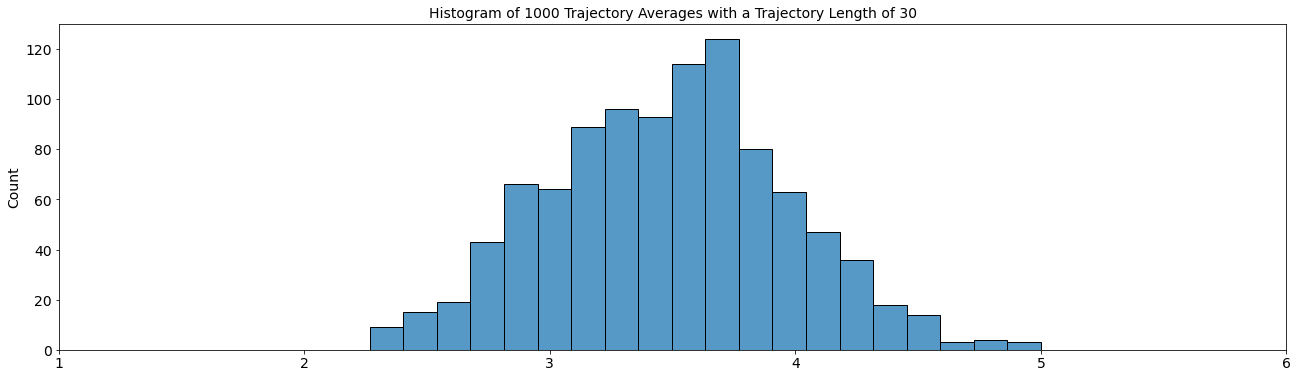

In [79]:
clt = CLT(T, pi_0, 30)
samples_30 = clt.calculate_means(1000)
clt.plot_histogram()
clt.print_stats()

<div class="alert alert-info">
3. The distribution looks normal-ish. The empirical mean is indeed very close to 3.5 (as calculated above), with the standard deviation of ~0.48
</div>

##### 4.B
Construct 1000 trajectories, each of length 500.
1. What do you expect the average value of all 500 numbers in a trajectory to be?
2. Compute the average value of each such trajectory. Draw a histogram of the 1000 numbers you received, using 20 bins.
3. What does the distribution look like? What are the empirical mean and the std?

<div class="alert alert-info">
By the same argument, the average value along each trajectory is expected to be 3.5 (on average, across many trajectories). Since each trajectory is much longer now, the average in each individualk trajectory is expected to be closer to the true mean, in other words the standard deviation of the trajectory means will be much smaller.
</div>

The mean of the means of randomly sampled trajectories is 3.5011180000000004
The std of the means of randomly sampled trajectories is 0.12167482104363253


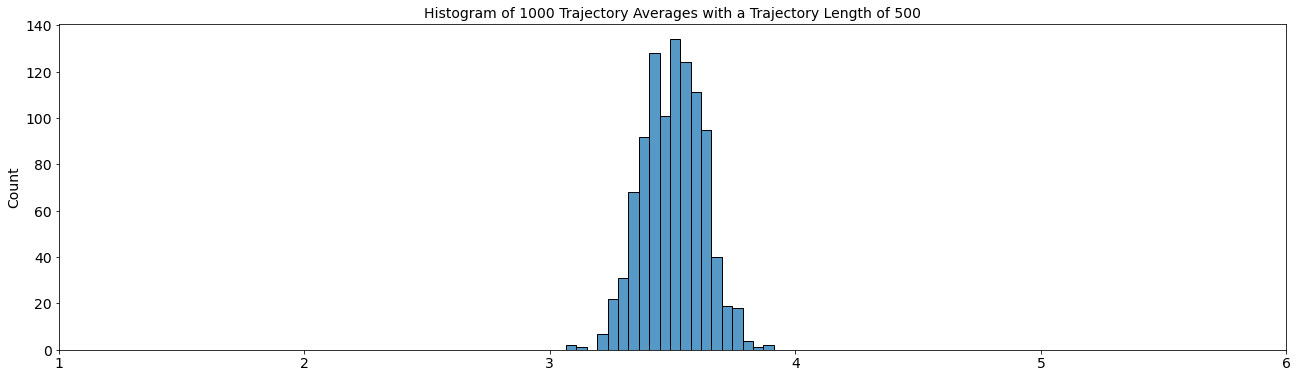

In [80]:
clt = CLT(T, pi_0, 500)
samples_500 = clt.calculate_means(1000)
clt.plot_histogram()
clt.print_stats()

<div class="alert alert-info">
3. The empirical mean is still ~3.5, but the standard deviation of the means of multiple trajectories is now ~0.12, i.e. it became smaller as expected.
</div>

#### 4.C
Draw normal fit curves on your two histograms.

In [81]:
clt30 = CLT(T, pi_0, 30)
samples_30 = clt30.calculate_means(1000)

clt500 = CLT(T, pi_0, 500)
samples_500 = clt500.calculate_means(1000)

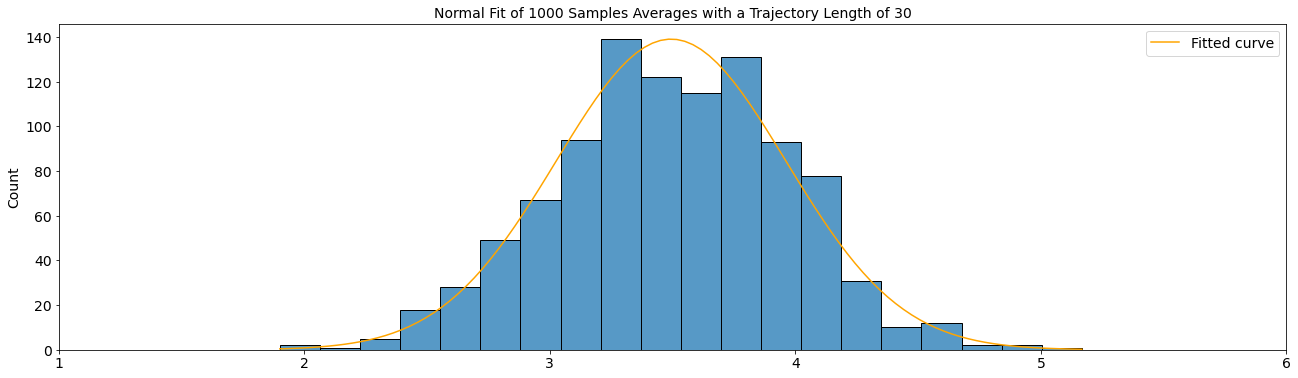

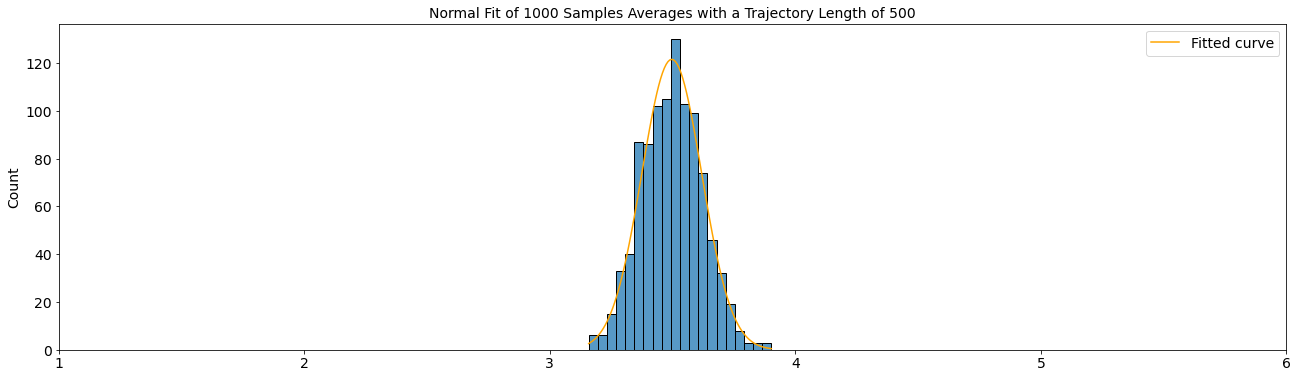

In [82]:
clt30.plot_normal_fit()
clt500.plot_normal_fit()

#### 4.D
Write a python code to calculate $Cov(X_0,X_i)$ for $i=1,..,500$ based on $\pi_0$ and $T$. 

Compute the values for our case.

In [83]:
def compute_cov(dist: np.array, matrix: np.array, iteration: int) -> np.array :
    state = np.arange(1, dist.shape[0] + 1, dtype=int)
    history = np.empty(iteration)
    T_pow = np.identity(len(matrix))
    for i in range(0, iteration):
        T_pow = np.dot(T_pow, matrix)
        history[i] = sum([(i + 1) * (j + 1) * dist[i] * T_pow[i][j] for i in range(len(matrix)) for j in range(len(matrix))]) - np.dot(state, dist) * np.dot(state, np.dot(dist, T_pow))
    return history

In [84]:
compute_cov(pi_0, T, 500)

array([ 1.11666667e+00,  5.16666667e-01,  2.52666667e-01,  1.25466667e-01,
        6.25866667e-02,  3.12666667e-02,  1.56282667e-02,  7.81314667e-03,
        3.90637867e-03,  1.95315067e-03,  9.76567627e-04,  4.88282275e-04,
        2.44140830e-04,  1.22070353e-04,  6.10351644e-05,  3.05175798e-05,
        1.52587894e-05,  7.62939460e-06,  3.81469728e-06,  1.90734863e-06,
        9.53674318e-07,  4.76837160e-07,  2.38418581e-07,  1.19209290e-07,
        5.96046448e-08,  2.98023242e-08,  1.49011630e-08,  7.45058237e-09,
        3.72529207e-09,  1.86264693e-09,  9.31324351e-10,  4.65663064e-10,
        2.32828867e-10,  1.16415322e-10,  5.82094373e-11,  2.91038305e-11,
        1.45501389e-11,  7.27773397e-12,  3.63620245e-12,  1.81898940e-12,
        9.09494702e-13,  4.52970994e-13,  2.25597319e-13,  1.11910481e-13,
        5.86197757e-14,  2.84217094e-14,  1.77635684e-14,  1.06581410e-14,
        5.32907052e-15, -1.77635684e-15,  1.77635684e-15,  0.00000000e+00,
        0.00000000e+00, -

### Question 5 - Distributions (16 Points)

Let $X$ be a random variable. Consider the number $q$ so that $P(X\le q)=0.8$ (assume that such a value exists).

Consider a sample $\vec{x}(n) = x_1,...,x_n$ sampled independently from $X$. Denote the sorted observations by: $a_1 \le a_2 \le ... \le a_n$. Also assume that $n \ge 100$.

Let $R(\vec{x}(n))$ be the largest index $i \in {1,...,n}$ such that $a_i \le q$. If $a_1 > q$ then $R = 0$.

1. What is $P(R = 0)$?
1. What is the distribution of $R$?
1. Given $n$, write code that computes an index $\lambda (n)$ so that $P(a_{\lambda (n)} \le q) \ge 0.9$ and $P(a_{\lambda (n)+1} \le q) < 0.9$.
1. Let $X \sim Unif(0,1)$, $q$ as above and $n=100$. Compute $\lambda (n)$ as above. Run 200 experiments that calculate $a_{\lambda (n)}$ for independent drawing from $X$. How many times did you observe $a_{\lambda (n)} \le q$?

<div class="alert alert-info">
1. If $R=0$ that means that $x_i > q$ for all $i$. The probability for any given observation to be greater than $q$ is $P(X > q) = 1 - P(X \leq q) = 1 -0.8 = 0.2$. Since the observations are independent, we have $P(X_1 > q, X_2 > q, ..., X_n > q) = P(X_1 > q) P(X_2>q) ... P(X_n>q) = 0.2^n$. If $n \geq 100$, this number is very close to 0 ( $ < 1.27\cdot 10^{-70}$ ).
    </div>

<div class="alert alert-info">2. $R$ is defined as the largest index in the *list of sorted observations* such that $a_i \leq q$. This literally means that if $R=k$, then we have $k$ observations $x_i$ that are less than $q$ (after sorting they will become $a_1, ..., a_k$), and the remaining observations are greater than $q$ (and thus after sorting they will become $a_{k+1}, ... a_n$). Thus, we are essentially considering a bernoulli variable (two possible outcomes): $Z=\{ X > q, X \leq q\}$,  with "success" probability $p=0.8$. Those bernoulli variables are independent as each $x_i$ can end up being greater or less than $q$ independent of all other observations in the sample. If after sampling variable $X$ $n$ times we end up with $k$ values below $q$ (and thus after sorting them we will have exactly $k$ values $a_i$ below $q$, so $R=k$), then it is equivalent to saying that we have $n$ trials of bernoulli variable $Z$ and we observed $k$ successes.

$\ \ \ \ \ \ $In other words, we need the distribution of $k$ successes out of $n$ independent bernoulli trials, which is Binomial: $P(R=k) = {\tt Binomial}(n, 0.8) = C_n^{k} \cdot 0.8^k \cdot 0.2^{n-k}$  </div>

<div class="alert alert-info">
3. If $a_{\lambda(n)} \leq q$, that means that $R \geq \lambda(n)$ (since $R$ is defined as the largest index $k$ such that $a_k \leq q$). Hence, the first condition $P(a_{\lambda(n)} \leq q) \geq 0.9 $ is equivalent to $P(R \geq \lambda(n))\geq 0.9$, or $F_R(\lambda(n)-1) \leq 0.1$ where $F_R(k)=P(R<=k)=1-P(R>k)$ is the CDF of random variable $R$ (i.e. the CDF of Binomial as it was shown above). In a similar way, we can see that the second condition $P(a_{\lambda(n)+1} \leq q) < 0.9$ can be written as 
$P(R \geq \lambda(n)+1)< 0.9$, or $F_R(\lambda(n)) > 0.1$.
    
From the above, we can see that $\lambda(n)$ is such number that as we go from $k=\lambda(n)-1$ to $k\lambda(n)$ the value of Binomial CDF $F_R(k)$ crosses from $\leq 0.1$ to $>0.1$. In other words, we want the 10% percentile of the binomial CDF.
    
Here's the code that computes that number (we use $n=100$ case as an example):</div>

In [85]:
n=100

def lam(n, p, q):
    return st.binom.ppf(q=0.1,n=n,p=0.8)

lam(n=n, p=0.8, q=0.1)

75.0

<div class="alert alert-info">
If $X \sim {\tt Unif}(0,1)$, then $P(X \leq q)=0.8$ when $q=0.8$. The theoretical value of $\lambda(n)$ is given above and is equal to 75.
Let us run the simulation:
</div>

In [86]:
q = 0.8
N_iter = 200 # number of experiments to run
N_below = 0 # number of experiments, in which a_lambda(n) ended up being below q

for i in range(N_iter):

    # draw a sample of size n from uniform(0,1):
    s = st.uniform.rvs(size=n)

    # lambda(n):
    lam_n = int(lam(n=100, p=0.8, q=0.1)) # same as above, lambda(n)=75 with these parameters

    # get the a_lambda(n). i.e. the element of the *sorted* sample s at position lambda(n):
    a_lambda = np.sort(s)[ lam_n - 1 ] 

    if a_lambda <= q: N_below += 1

print("The number of experiments with a_lambda(n) below 0.8:", N_below)
print("The probability P(a_lambda(n) <= q), from the simulation:", N_below/N_iter)

The number of experiments with a_lambda(n) below 0.8: 171
The probability P(a_lambda(n) <= q), from the simulation: 0.855
